In [57]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import glob
import os

### Utility Functions:

#### get_results_path()

In [111]:
def get_results_path(model: str = "multi_model",
                     num_runs: int= 1000,
                     fve: float = np.nan,
                     train_size: int = 10000,
                     prediction_length: int = 100,
                     eval_metric: str = "RMSE",
                     ci_level: float = 0.95,
                     time_limit: int = 600,
                     max_epochs: int = 1,
                     base_dir: str = "./") -> str:
    """
    Constructs a standardized path for results files based on input parameters.

    Args:
        model: Name of the model type
        num_runs: Total experimental runs
        fve: Fraction of variance explained
        train_size: Training set size
        prediction_length: Forecast horizon
        eval_metric: Evaluation metric
        ci_level: Confidence level
        time_limit: Training time limit
        verbosity: Logging level
        max_workers: Maximum parallel workers
        base_dir: Base directory in which result folders are stored

    Returns:
        Full file path to the corresponding `results.parquet` file for the given 
        configuration of a experiment.
    """
    filename = (f"{model}_{num_runs}_{fve}_{train_size}_{prediction_length}_"
                f"{eval_metric}_{ci_level}_{time_limit}_{max_epochs}/results.parquet")
    return os.path.join(base_dir, filename)


#### find_pareto_front_hyperidx()

In [112]:
def find_pareto_front_hyperidx(x:np.ndarray, y:np.ndarray):
    """
    Identifies the Pareto frontier from given x and y data points.
    
    Args: 
        x: Array of x-coordinates
        y: Array of y-coordinates
        
    Returns:
        tuple: - Indices of Pareto optimal points
               - Coordinates of Pareto frontier points
               - Enhanced boundary coordinates for plotting
    """
    paretof_hyper_idxs = []
    i = np.argmin(y)  # start from the point with the lowest y
    paretof_hyper_idxs.append(i)

    # iteratively find the next point with lower x and best (lowest) y among those
    while np.any(x < x[i]):
        idx = np.argwhere(x < x[i])
        i0 = np.argmin(y[idx])
        i = idx[i0][0]
        paretof_hyper_idxs.append(i)

    # get the boundary points' coordinates from selected indices
    x_boundary = np.array(x[paretof_hyper_idxs]) 
    y_boundary = np.array(y[paretof_hyper_idxs])

    #  copy for enhanced version
    x_enhanced_boundary = np.array(x[paretof_hyper_idxs])
    y_enhanced_boundary = np.array(y[paretof_hyper_idxs])
   
    # extend original boundary by adding padding on both ends for visual closure
    n_b = x_boundary.size
    x_boundary = np.insert(x_boundary,[0,n_b],[np.max(x),np.min(x)])
    y_boundary = np.insert(y_boundary,[0,n_b],[np.min(y),np.max(y)])
    
    # construct enhanced boundary by duplicating x/y to form horizontal segments (step plot)
    n_eb = x_enhanced_boundary.size
    idx = np.arange(0,(n_eb-1))
    x_enhanced_boundary = np.insert(x_enhanced_boundary,idx+1,x_enhanced_boundary[idx])
    y_enhanced_boundary = np.insert(y_enhanced_boundary,idx+1,y_enhanced_boundary[idx+1])

    # add max/min to both ends of enhanced boundary for full plot span
    n_eb = x_enhanced_boundary.size
    x_enhanced_boundary = np.insert(x_enhanced_boundary,[0,n_eb],[np.max(x),np.min(x)])
    y_enhanced_boundary = np.insert(y_enhanced_boundary,[0,n_eb],[np.min(y),np.max(y)])
   
    
    return (paretof_hyper_idxs, x_boundary, y_boundary, 
            x_enhanced_boundary, y_enhanced_boundary) 

#### make_base_plot()

In [88]:
def make_base_plot(
        results: pd.DataFrame, 
        h: list[int], 
        metric: str, 
        title: str, 
        alpha = 1,
        log_scale: bool=False,
        flux_MAD: float = None
        ) -> tuple[ggplot, pd.DataFrame | None, pd.DataFrame]:
    """
    Generates a base Pareto frontier plot using normalized RMSE or MAD, 
    depending on the data type.

    Filters and aggregates model evaluation results for specified forecast horizons,
    computes the Pareto frontier for a given model complexity metric, and
    returns a `ggplot` object with the frontier overlayed on the scatter plot.

    Args:
        results: The raw model evaluation results
        h: List of forecast horizons to include in the plot.
        metric: The x-axis metric to use, either 'flops' or 'num_params'.
        title: The title of the plot.
        alpha:  Transparency of the data points. Default is 1.
        log_scale: Whether to use logarithmic scale for the x-axis. Default is False.
        flux_MAD: If provided, use Normalized MAD instead of Normalized RMSE for the y-axis

    Returns:
        tuple: - generated Pareto frontier plot,
               - dataFrame of enhanced boundary segments,
               - processed and aggregated DataFrame with normalized error and Pareto flag
    """
    results = results[results["h"].isin(h)].copy() ### filter by given horizon

    ### compute evluation data for each model
    results = results.groupby(["hyper_idx"]).agg(
        mean_squared_error=("squared_error", "mean"),
        RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
        MAD=("squared_error", lambda x: np.median(np.sqrt(x))),
        coverage_accuracy=("coverage_flags", "mean"),
        flops = ("flops", "mean"),
        num_params = ("num_params", "mean"),
        sd = ("sd", "mean")
    )

    if flux_MAD is None:
        results["normalized_rmse"] = results["RMSE"] / results["sd"]
        ylab = "Normalized RMSE"
    else:
        results["normalized_rmse"] = results["MAD"] / flux_MAD
        ylab = "Normalized MAD"

    if metric == "flops":
        xlab = "Flops (K)"
    else:
        xlab = "Number of Parameters (K)"

    results.reset_index(drop=False, inplace=True)
    
    # get the idx and coordinates for pareto frontier, and enhanced boundary coordinates
    pareto_hyper_idx, x_b, y_b, x_eb, y_eb = find_pareto_front_hyperidx(
        results[metric].values, results["normalized_rmse"].values)
    
    # mark which models lie on the Pareto frontier
    results["boundary_flags"] = results["hyper_idx"].isin(pareto_hyper_idx)

    # create a DataFrame of the basic Pareto frontier curve
    boundary_df = pd.DataFrame({metric: x_b, "normalized_rmse": y_b})
    # create an enhanced boundary DataFrame for drawing segments between frontier points
    enhanced_boundary_df = pd.DataFrame(
        {metric: x_eb[:-1], "normalized_rmse": y_eb[:-1], "metric_end": x_eb[1:], 
         "normalized_rmse_end": y_eb[1:]})
    
    # if there is only one forecast horizon h, prepare a labeled DataFrame for plotting
    if len(h) == 1:
        enhanced_boundary_df2 = pd.DataFrame(
            {"h": h[0], "metric": metric, 
             "x": x_eb[:-1], "normalized_rmse": y_eb[:-1],
             "x_end": x_eb[1:], "normalized_rmse_end": y_eb[1:]})
        results["h"] = h[0] # assign the horizon value to all rows for consistency
       
    else: # don't return a horizon-specific boundary if multiple horizons are used
        enhanced_boundary_df2 = None

    plot = (
        ggplot(results, aes(x = metric, y = "normalized_rmse")) +
        geom_point(alpha = alpha) + # points for all models
        # red segments for Pareto frontier
        geom_segment(aes(x = metric, y = "normalized_rmse", 
                         xend = "metric_end", yend = "normalized_rmse_end"),
                     data = enhanced_boundary_df, color = "red") +
        # blue dots for frontier models
        geom_point(results[results["boundary_flags"]], color = "blue", size = 2) + 
        labs(x = xlab, y = ylab, title=title) +
        theme_bw()
    )

    if log_scale:
        plot = plot + scale_x_log10()

    return plot, enhanced_boundary_df2, results

#### make_pareto_frontier_plot()

In [79]:
def make_pareto_frontier_plot(
        results: pd.DataFrame, 
        h: list[int], 
        metric: str, 
        title: str, 
        alpha = 1,
        log_scale: bool=False, 
        add_oracle_NRMSE_line: bool=False, 
        fve: float=None,
        flux_MAD: float=None
        ) -> tuple[ggplot, list[int]]:
    """
    Generates a Pareto frontier plot for model evaluation results.

    This function visualizes the trade-off between model complexity and predictive 
    performance (normalized RMSE or normalized MAD). It highlights Pareto-optimal models 
    and optionally adds a reference line for oracle performance.

    Args:
        results: DataFrame containing model evaluation results with required columns
        h: List of forecast horizons to filter and include in the analysis
        metric: Complexity metric to be shown on the x-axis. Options: "flops" or "num_params"
        title: Title for the generated plot
        alpha: Transparency level for the scatter plot points. Default is 1.
        log_scale: Whether to apply logarithmic scaling to the x-axis. Default is False.
        add_oracle_NRMSE_line: Whether to add a reference line showing theoretical oracle 
                               NRMSE. Default is False.
        fve : Fraction of variance explained.
        flux_MAD : If provided, normalized MAD is used as the error metric instead of RMSE.

    Returns:
        tuple: - The Pareto frontier plot with model points and frontier overlay.
               - DataFrame containing enhanced boundary coordinates for frontier lines.
               - Aggregated and filtered DataFrame with computed metrics and Pareto flags.
    """
     
    plot, enhanced_boundary_df2, results = make_base_plot(results, h, metric, title, 
                                                          alpha, log_scale, flux_MAD)

    # if add_oracle_NRMSE_line:
    #     if flux_MAD is None:
    #         plot = plot + geom_hline(yintercept = np.sqrt(1-fve**min(h)), linetype = "dashed")
    #     else:
    #         arima_df = arima_df[arima_df["h"].isin(h)].copy()
    #         arima_df = arima_df.groupby("hyper_idx").agg(
    #               mean_squared_error=("squared_error", "mean"),
    #               RMSE=("squared_error", lambda x: np.sqrt(x.mean())),
    #               sd = ("sd", "mean")
    #               )
    #         arima_df["normalized_rmse"] = arima_df["RMSE"] / arima_df["sd"]
    #         plot = plot + geom_hline(yintercept = arima_df["normalized_rmse"], linetype = "dotted")
    
    return plot, enhanced_boundary_df2, results

#### make_multi_frontier_plot()

In [71]:
def make_multi_frontier_plot(dfs: list[pd.DataFrame], 
                             title: str, 
                             result_list: list[pd.DataFrame], 
                             fve: float = np.nan
                             ) -> ggplot:
    """
    Creates a multi-horizon Pareto frontier plot showing normalized RMSE vs. model complexity.

    This function combines results across multiple forecast horizons to generate a 
    comparative plot of Pareto frontiers. It includes dashed reference lines representing 
    theoretical lower bound if FVE is provided.

    Args:
        dfs: List of DataFrames, each containing enhanced Pareto frontier segments for a 
             given horizon
        title: Title to display on the plot.
        result_list: List of raw or aggregated model results, used for background scatter 
                     lot points.
        fve: Fraction of Variance Explained.

    Returns:
        A ggplot object visualizing the Pareto frontiers for multiple horizons.
    """
    df = pd.concat(dfs) # combine all enhanced Pareto frontier dataframes
    results = pd.concat(result_list) # combine all model results for plotting individual points
    hs = df["h"].unique()
    line_yintercepts = [] # data for theoretical lines at each horizon
    a = np.arange(1, 300)**(-0.6)

    # compute theoretical line for each horizon
    for h in hs:
        line_yintercept = np.sqrt(1 - fve**h)
        line_yintercepts.append(line_yintercept)

    yintercept_df = pd.DataFrame({"h": hs, "yintercept": line_yintercepts})

   
    df["h"] = pd.Categorical(df["h"])
    yintercept_df["h"] = pd.Categorical(yintercept_df["h"])
    results["h"] = pd.Categorical(results["h"])

    metric = df["metric"].iloc[0]
    if metric == "flops":
        xlab = "Flops (K)"
    else:
        xlab = "Number of Parameters (K)"
    plot = (
        ggplot(df, aes(x = "x", y = "normalized_rmse", 
                       xend = "x_end", yend = "normalized_rmse_end", color = "h")) +
        # plot individual model results
        geom_point(aes(x = metric, y = "normalized_rmse", color = "h"), alpha = 0.1, 
                   data = results, inherit_aes = False, shape = ".") +
        # plot Pareto frontier segments
        geom_segment(size = 2) +
        # add dashed horizontal theoretical lines per horizon
        geom_hline(aes(yintercept = "yintercept", color = "h"), data = yintercept_df, 
                   linetype = "dashed") +
        labs(x = xlab, y = "Normalized RMSE", title=title) +
        theme_bw()
    )
    return plot

### Plots of AR(1)

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\IPython\lib\pretty.py:794: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


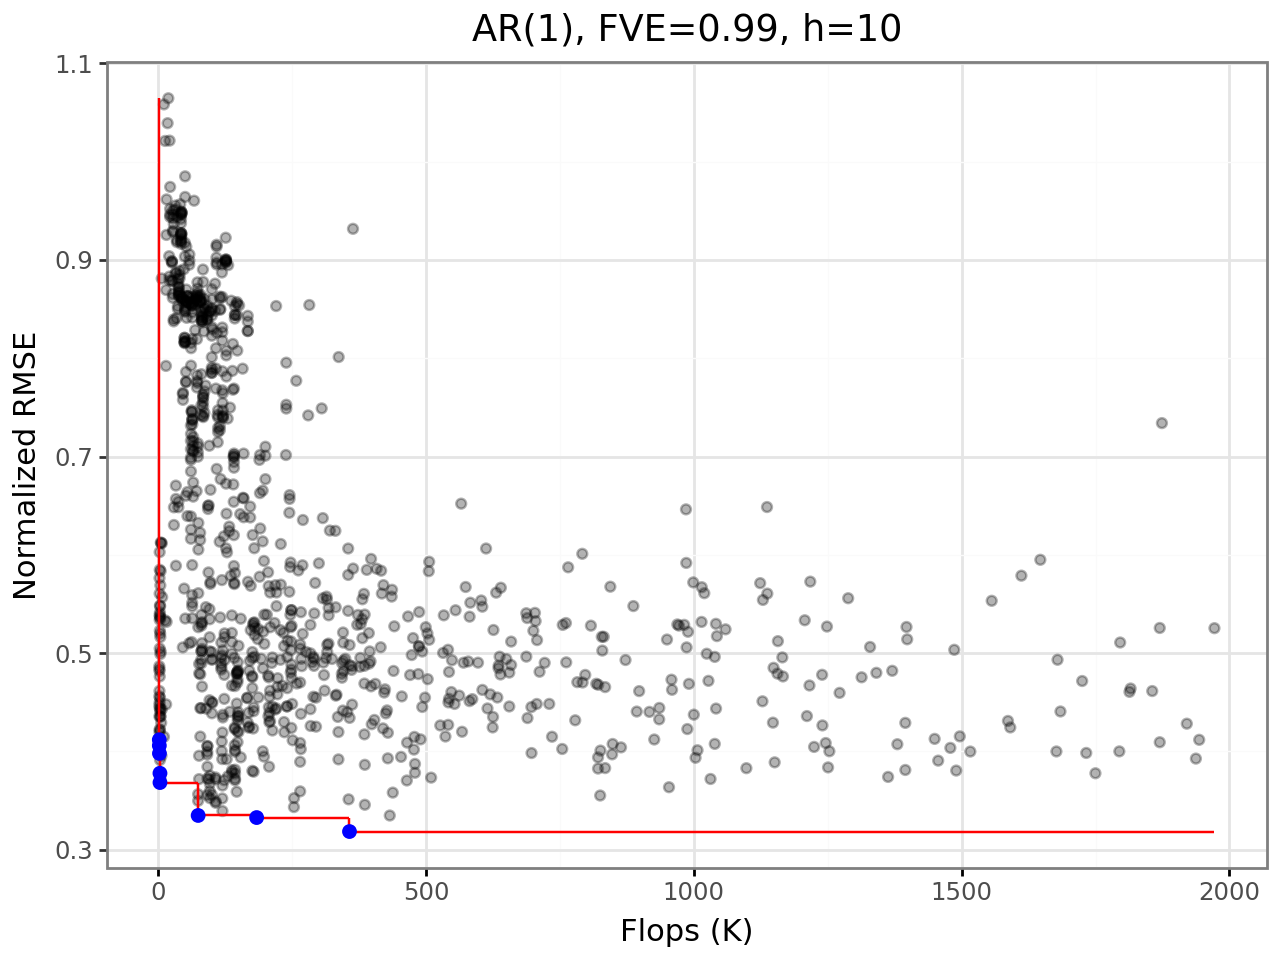

(<Figure Size: (640 x 480)>,
      hyper_idx  mean_squared_error      RMSE       MAD  coverage_accuracy  \
 0            0           80.941948  8.996774  6.477292               0.97   
 1            1           15.187967  3.897174  2.753706               0.97   
 2            2           25.073818  5.007376  2.674625               0.92   
 3            3           16.039348  4.004916  3.050067               0.97   
 4            4           16.177947  4.022182  2.735153               0.95   
 ..         ...                 ...       ...       ...                ...   
 995        995           26.714882  5.168644  3.201483               0.90   
 996        996           95.004226  9.747011  5.911898               0.94   
 997        997           17.850951  4.225039  2.784215               0.97   
 998        998           23.200825  4.816723  2.986952               0.98   
 999        999           20.832834  4.564300  3.545508               0.99   
 
        flops  num_params        

In [113]:
results_df = pd.read_parquet(get_results_path(fve=0.99))
arima_df =  pd.read_parquet(get_results_path(model="ARIMA_model", num_runs=1, fve=0.99))

title = "AR(1), FVE=0.99, h=10"
plot, _, enhanced_boundary_df_2 = make_pareto_frontier_plot(results=results_df, h=list([10]), metric="flops", title=title, alpha=0.3, log_scale=False, add_oracle_NRMSE_line=False, fve=0.99)
plot, enhanced_boundary_df_2

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 2 rows containing missing values.


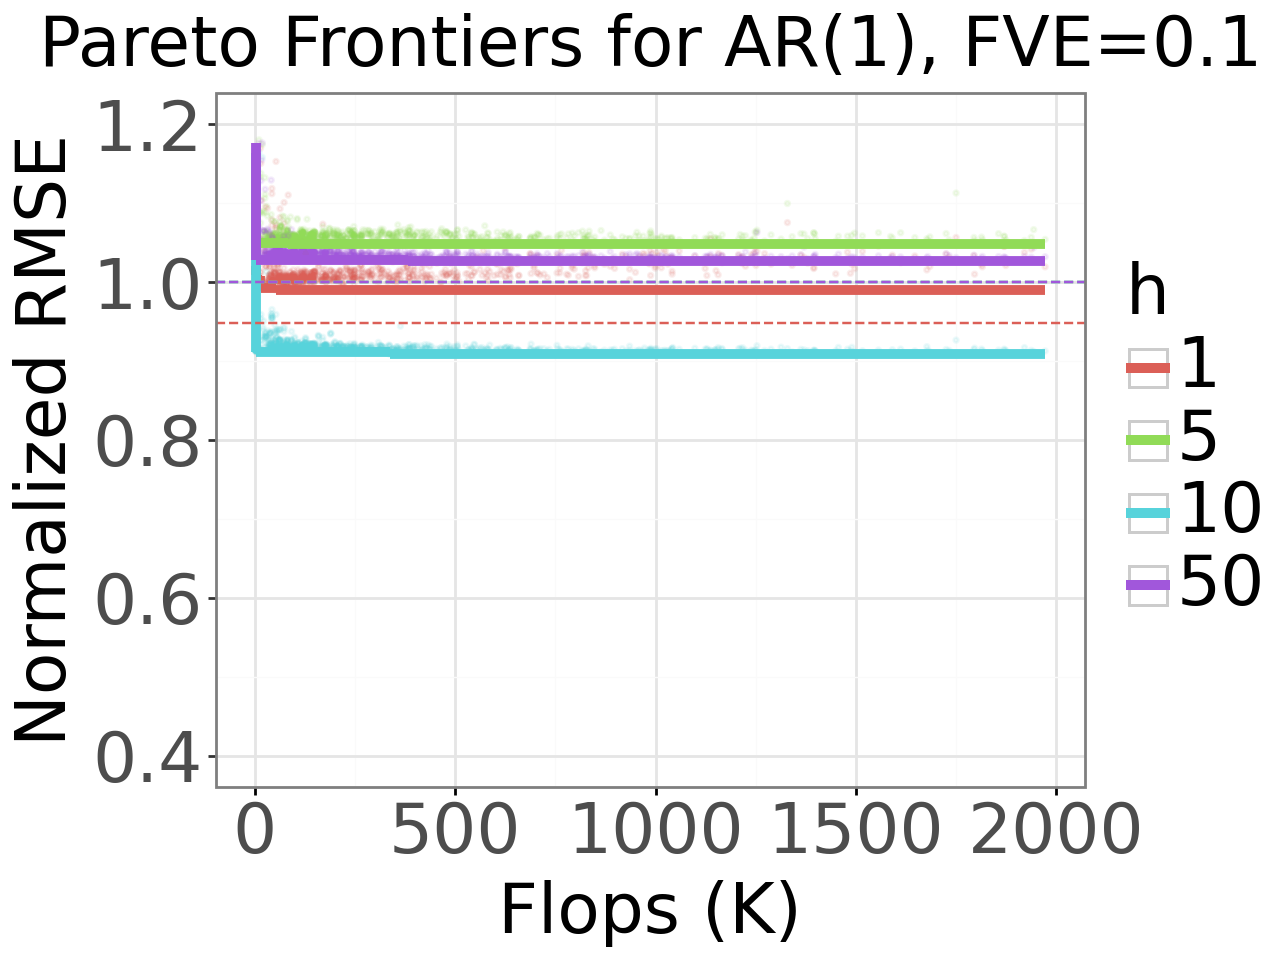

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 4 rows containing missing values.


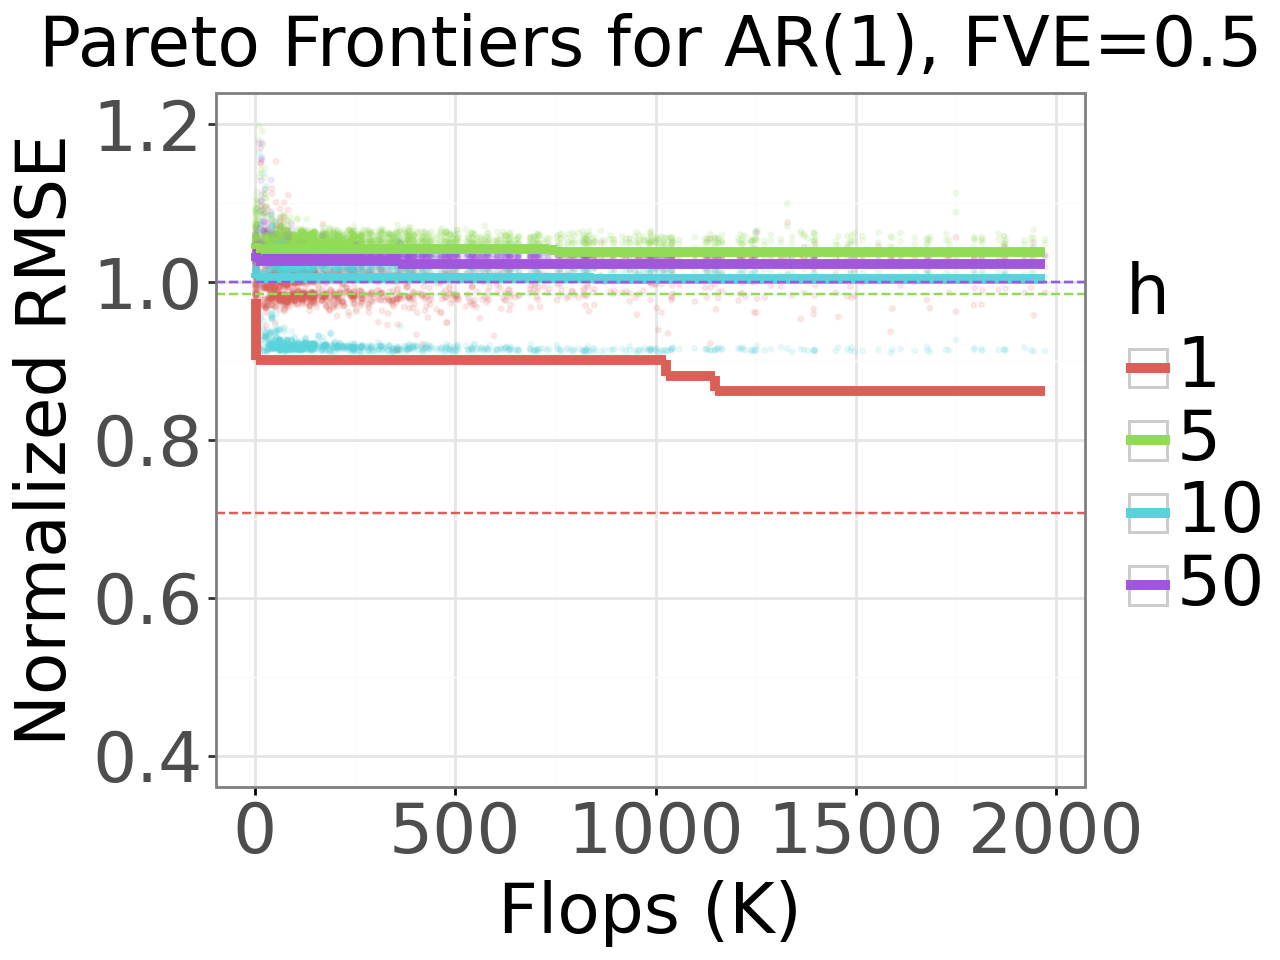

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 93 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 6 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_hline : Removed 1 rows containing missing values.


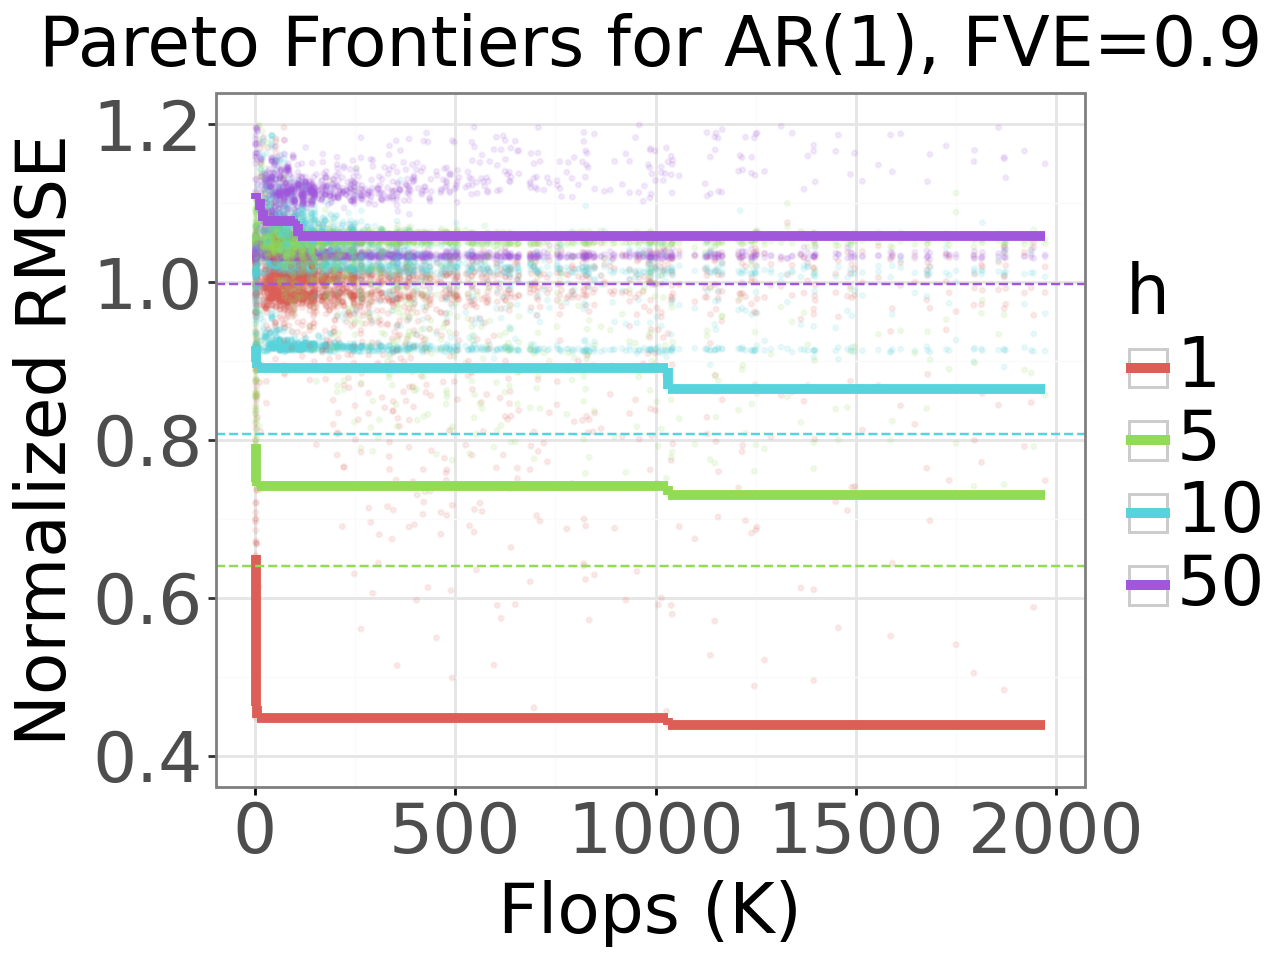

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 722 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 38 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_hline : Removed 3 rows containing missing values.


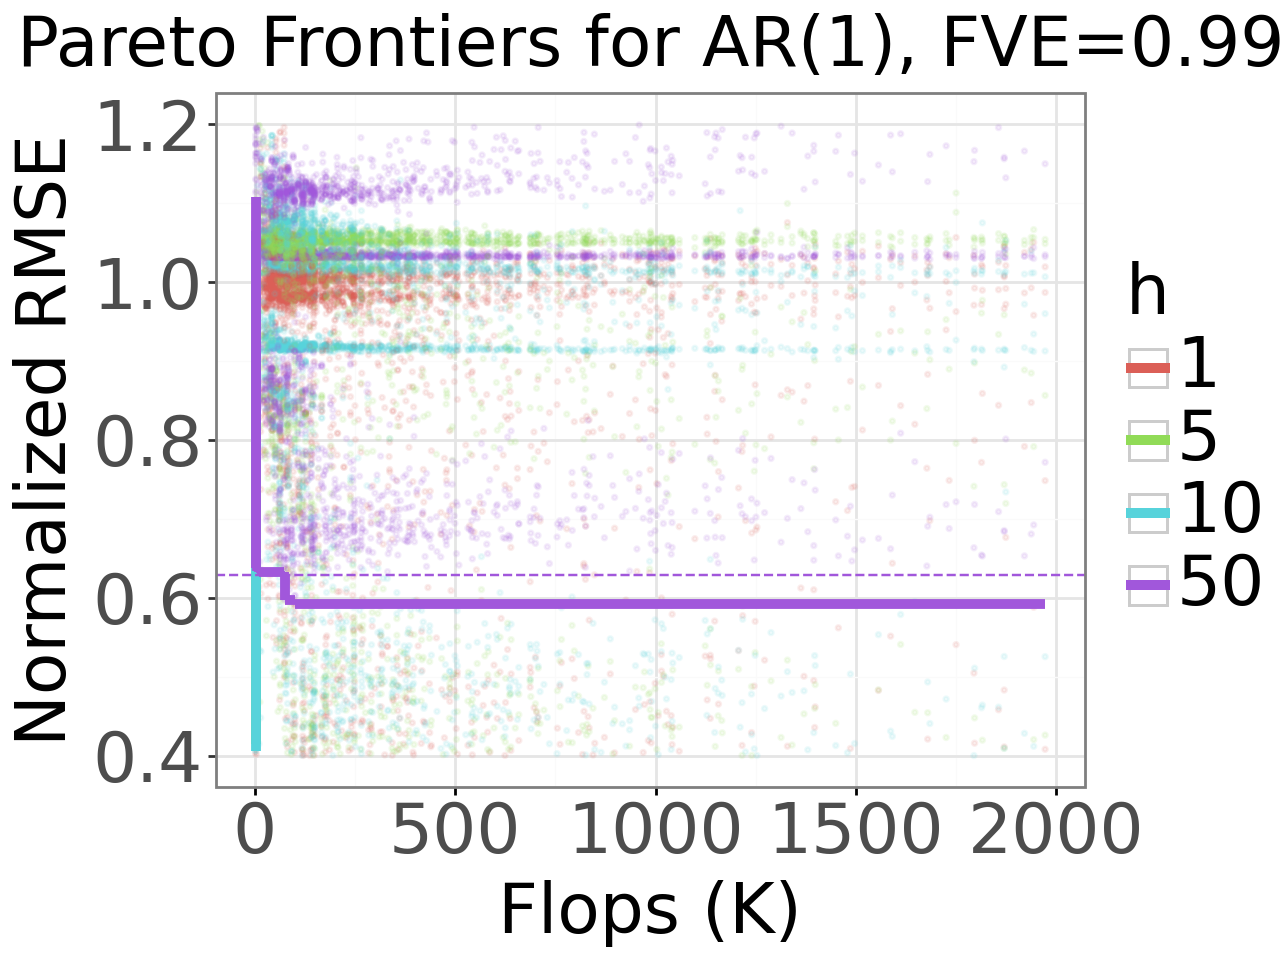

In [104]:
save = False
hs = [1, 5, 10, 50]
fves = [0.1, 0.5, 0.9, 0.99]
result_list = []

### for each possible fve
for fve in fves:
    dfs = []
    title = f"Pareto Frontiers for AR(1), FVE={fve}"
    fve_df = pd.read_parquet(get_results_path(fve=fve))
    
    ### combine the results of single pareto frontier plots at different horizons
    for h in hs:
        _, enhanced_boundary_df_2, results = make_pareto_frontier_plot(fve_df, [h], "flops", "", 0.3, False, False, fve)
        dfs.append(enhanced_boundary_df_2)
        result_list.append(results)

    ### creat a combined plot with multiple frontiers    
    plot = make_multi_frontier_plot(dfs, title, result_list, fve) + ylim(0.4, 1.2) + theme(text=element_text(size=25))
    plot.show()
    if save:
        save_as_pdf_pages([plot], f"{title}.pdf")

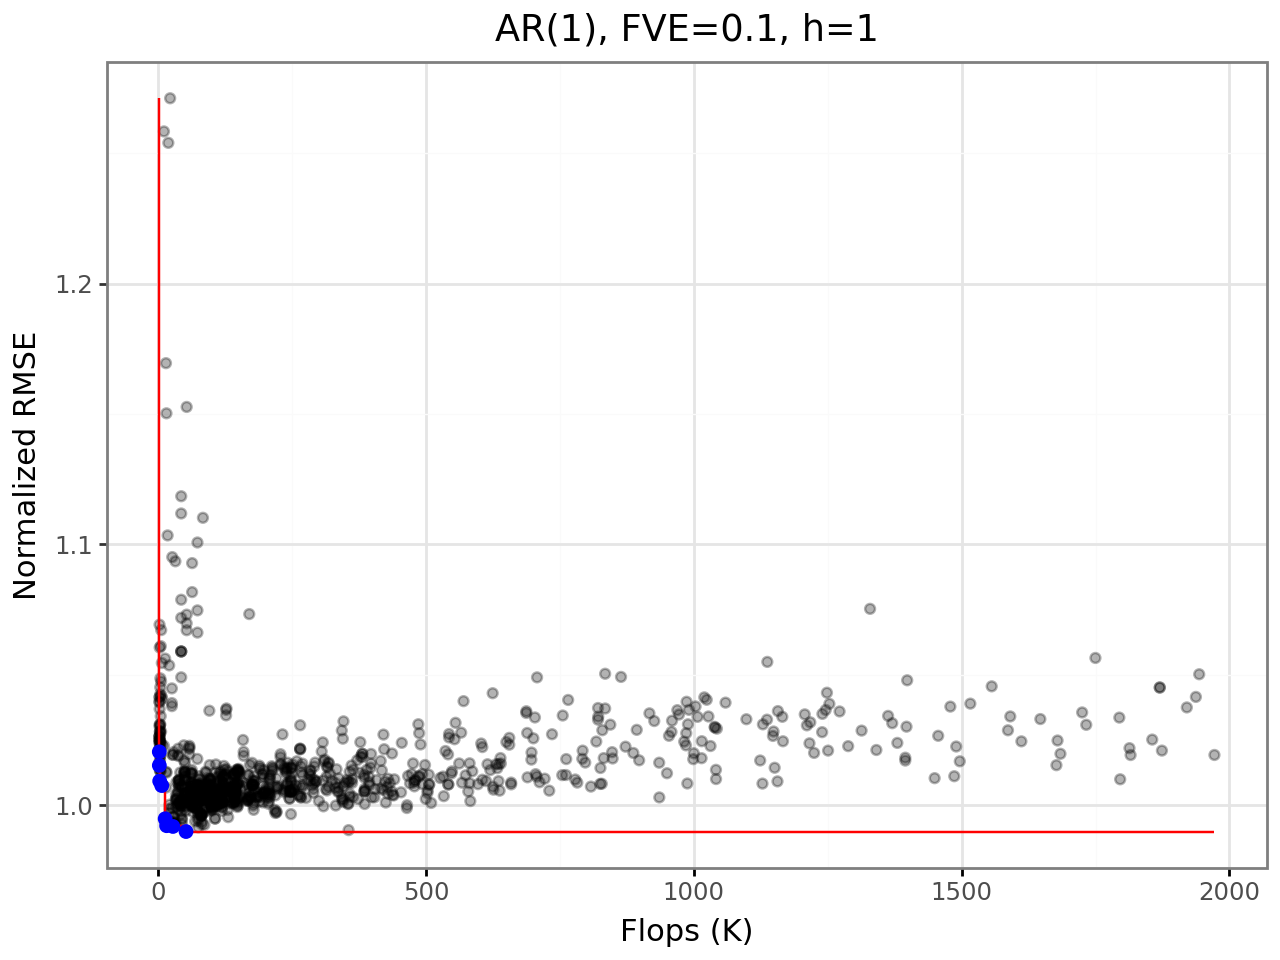

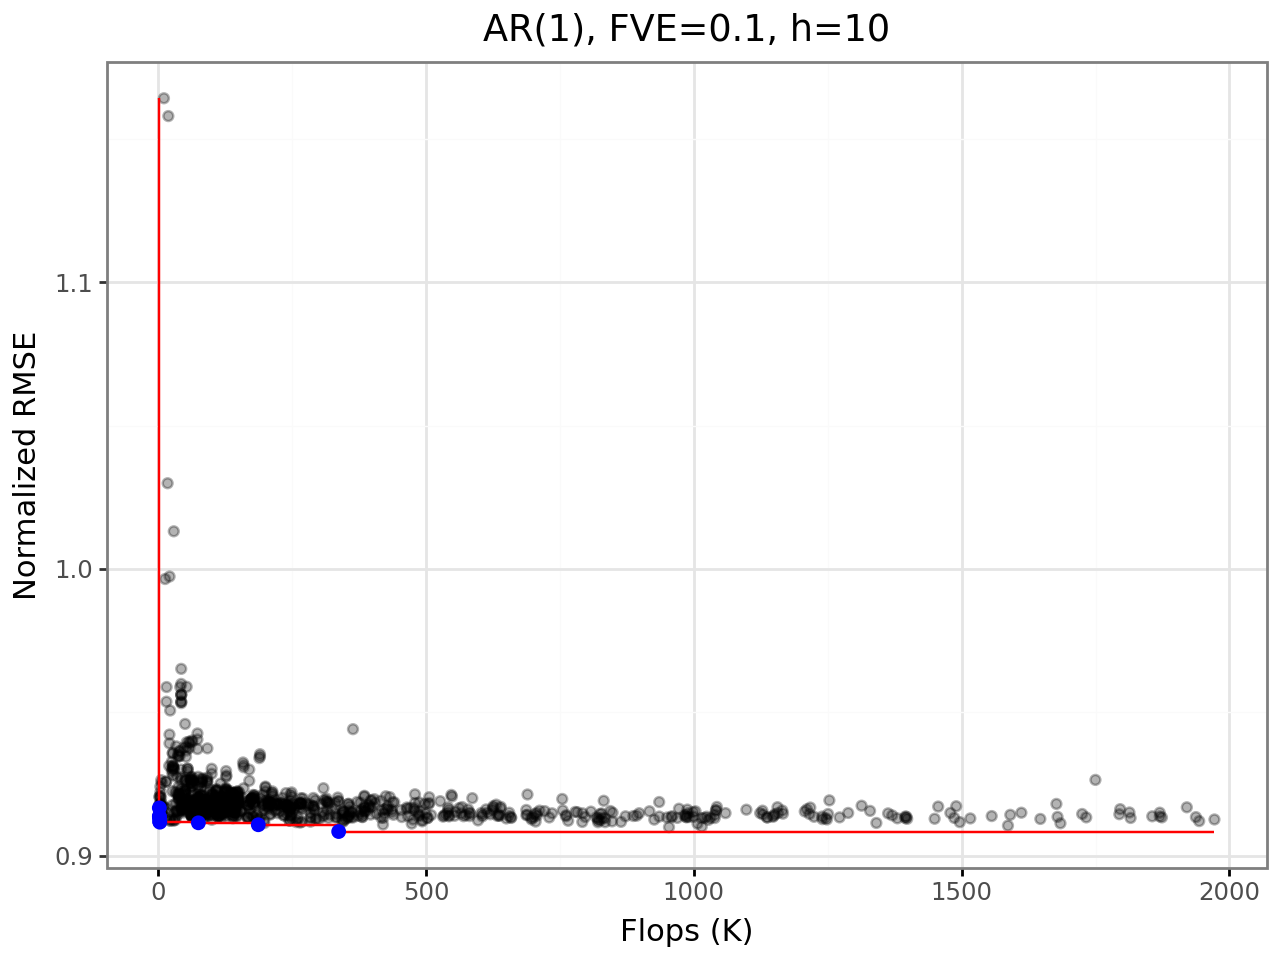

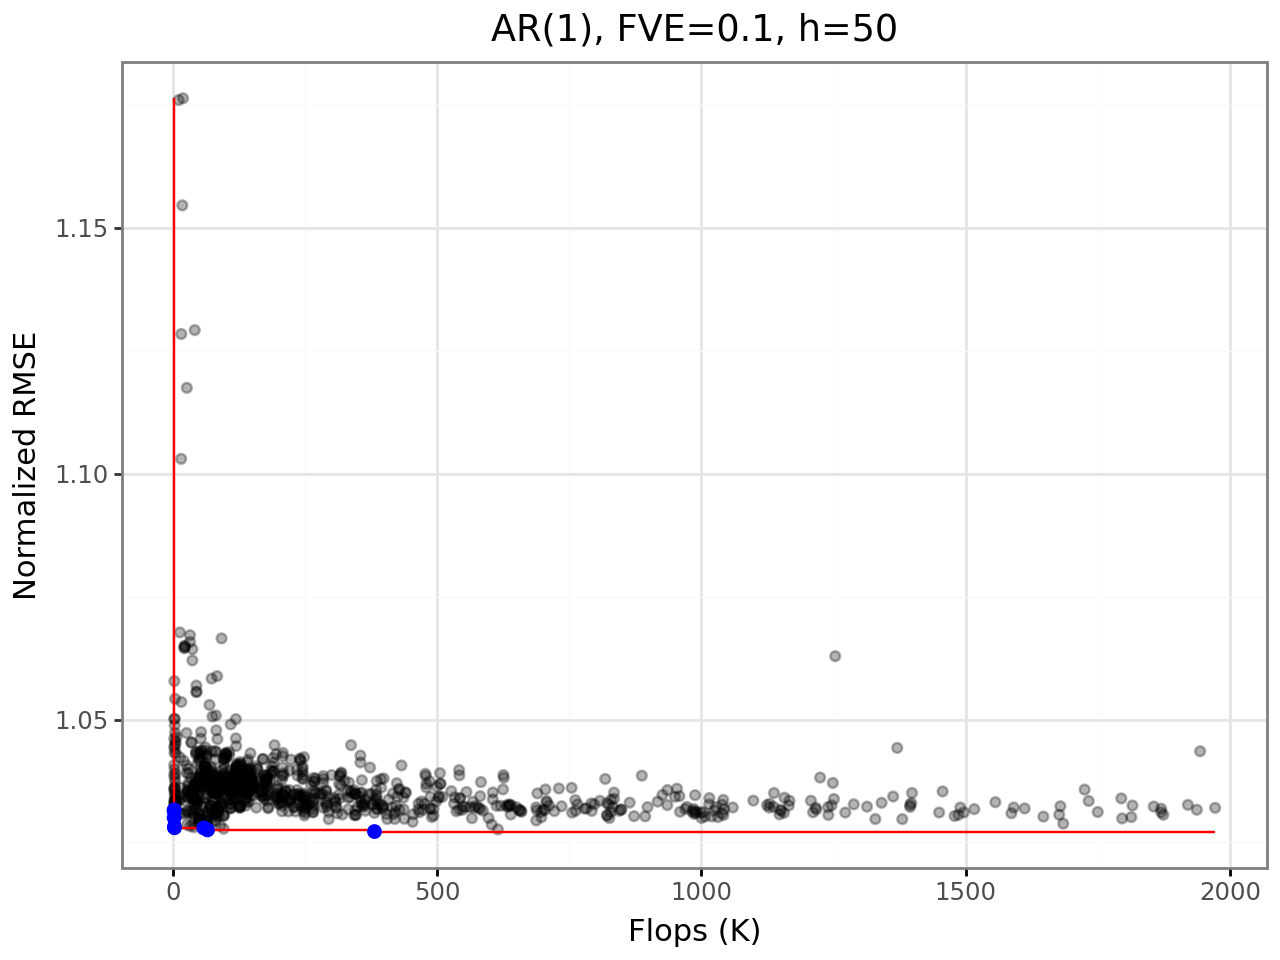

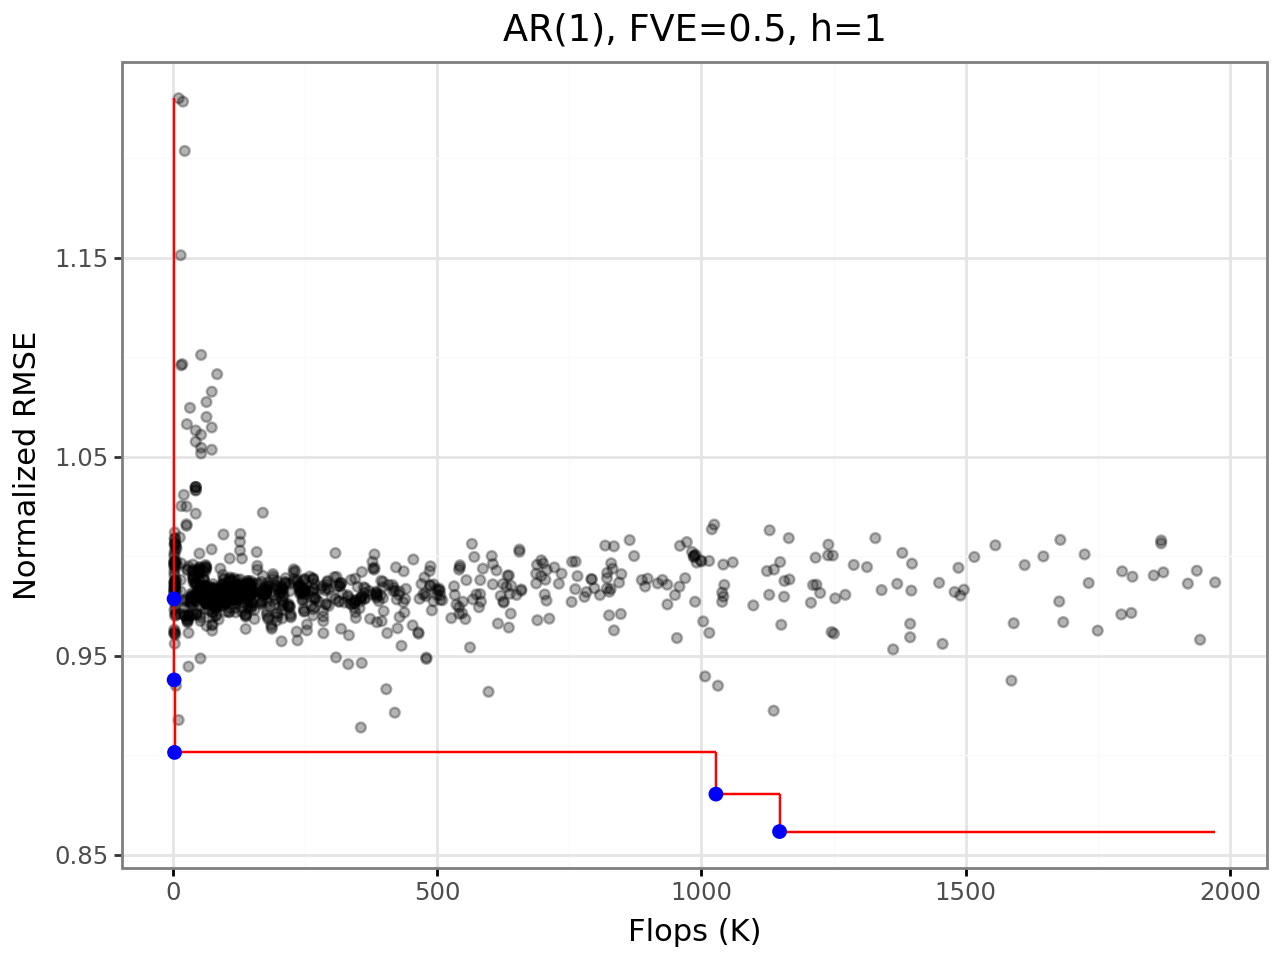

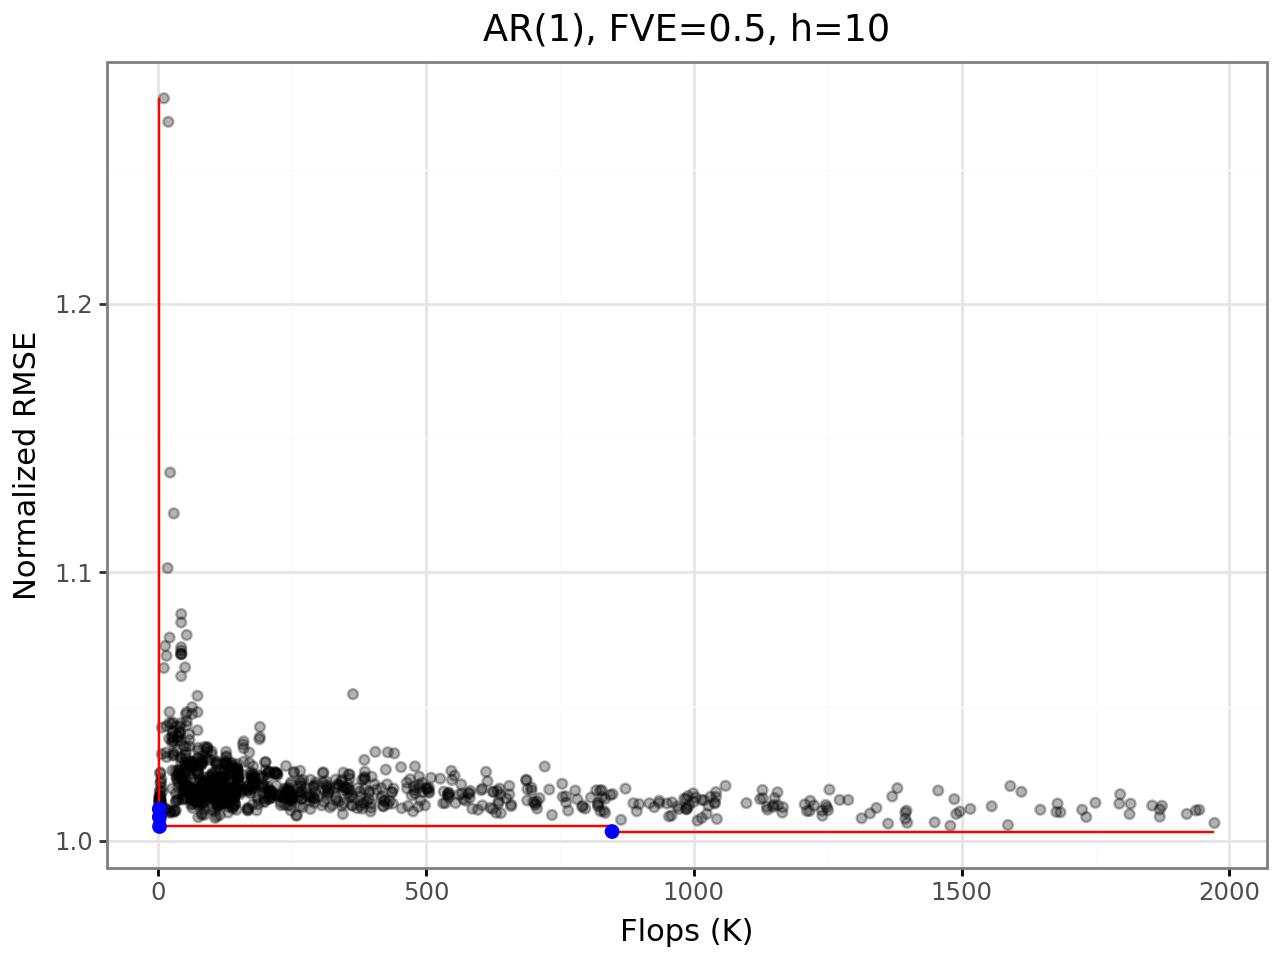

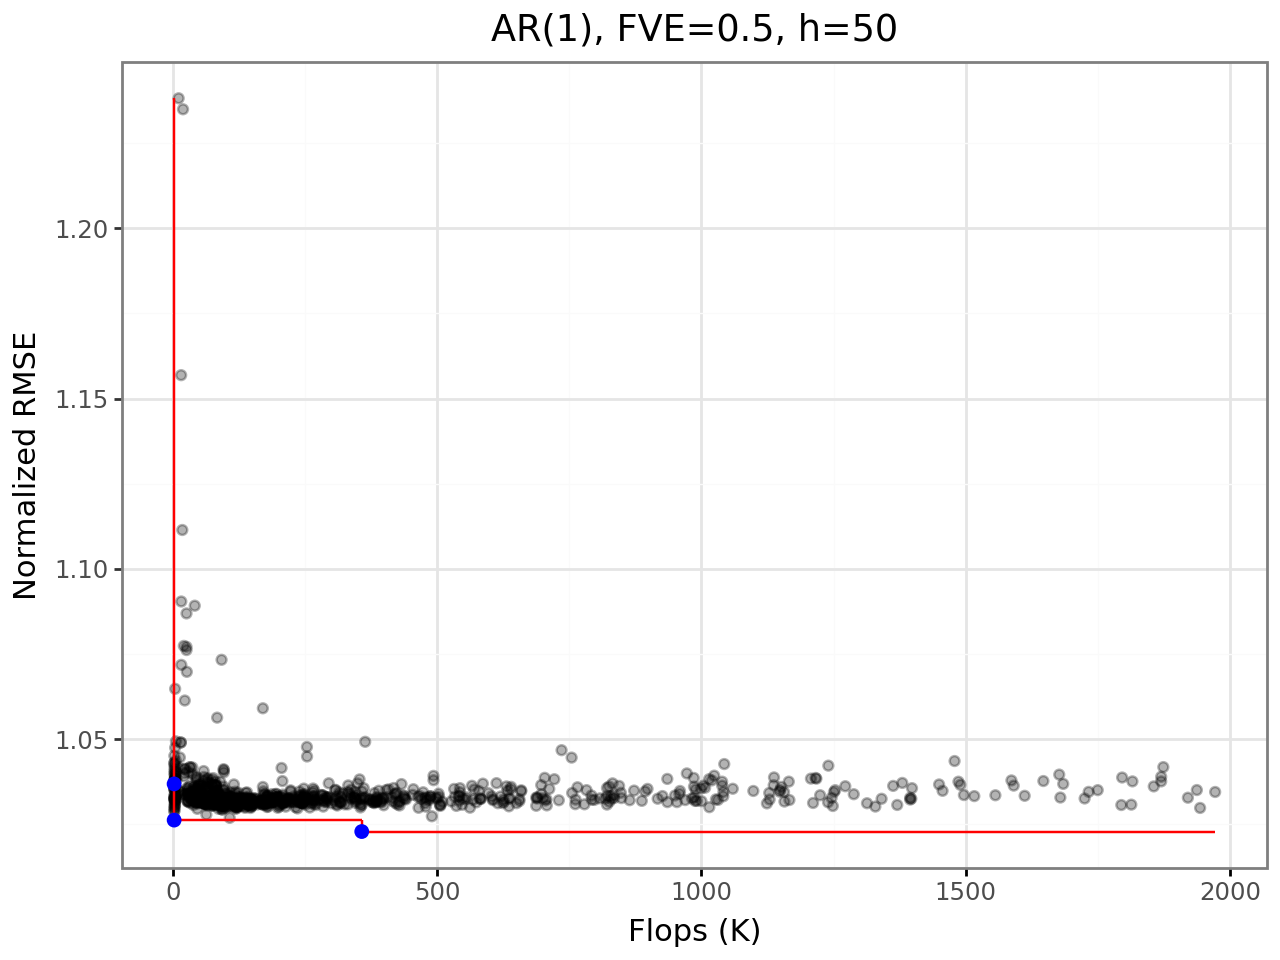

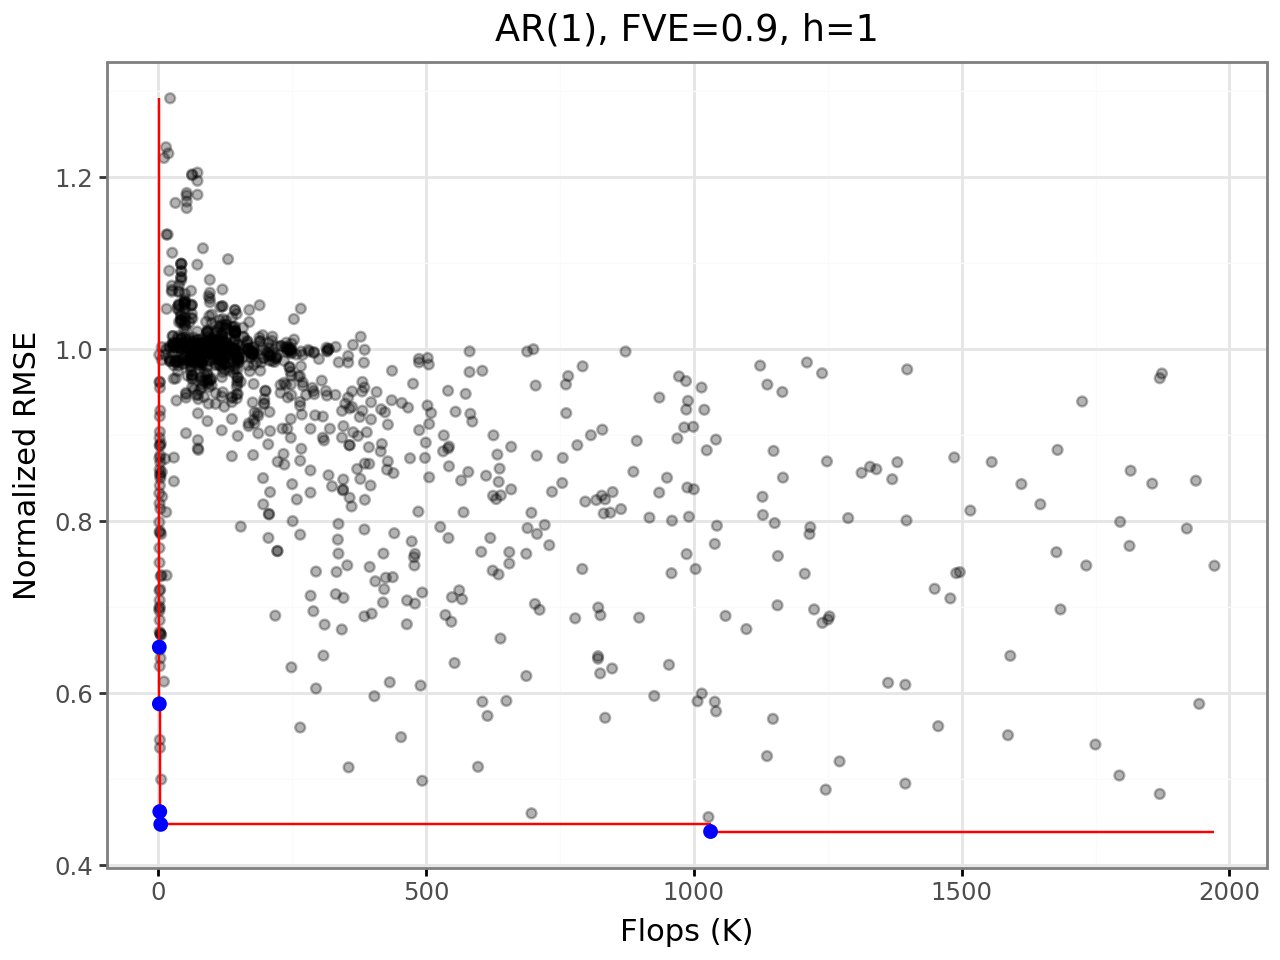

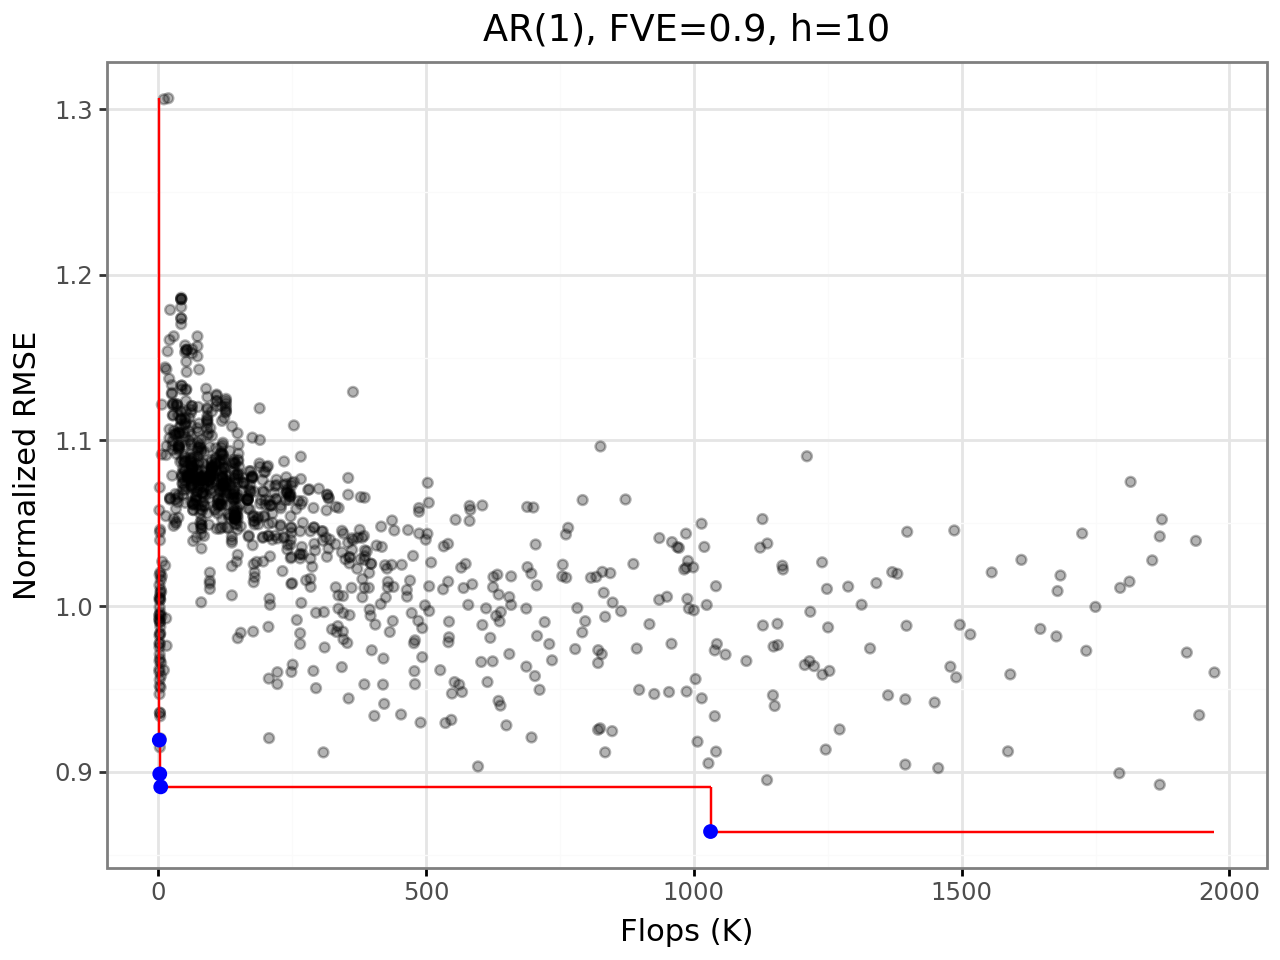

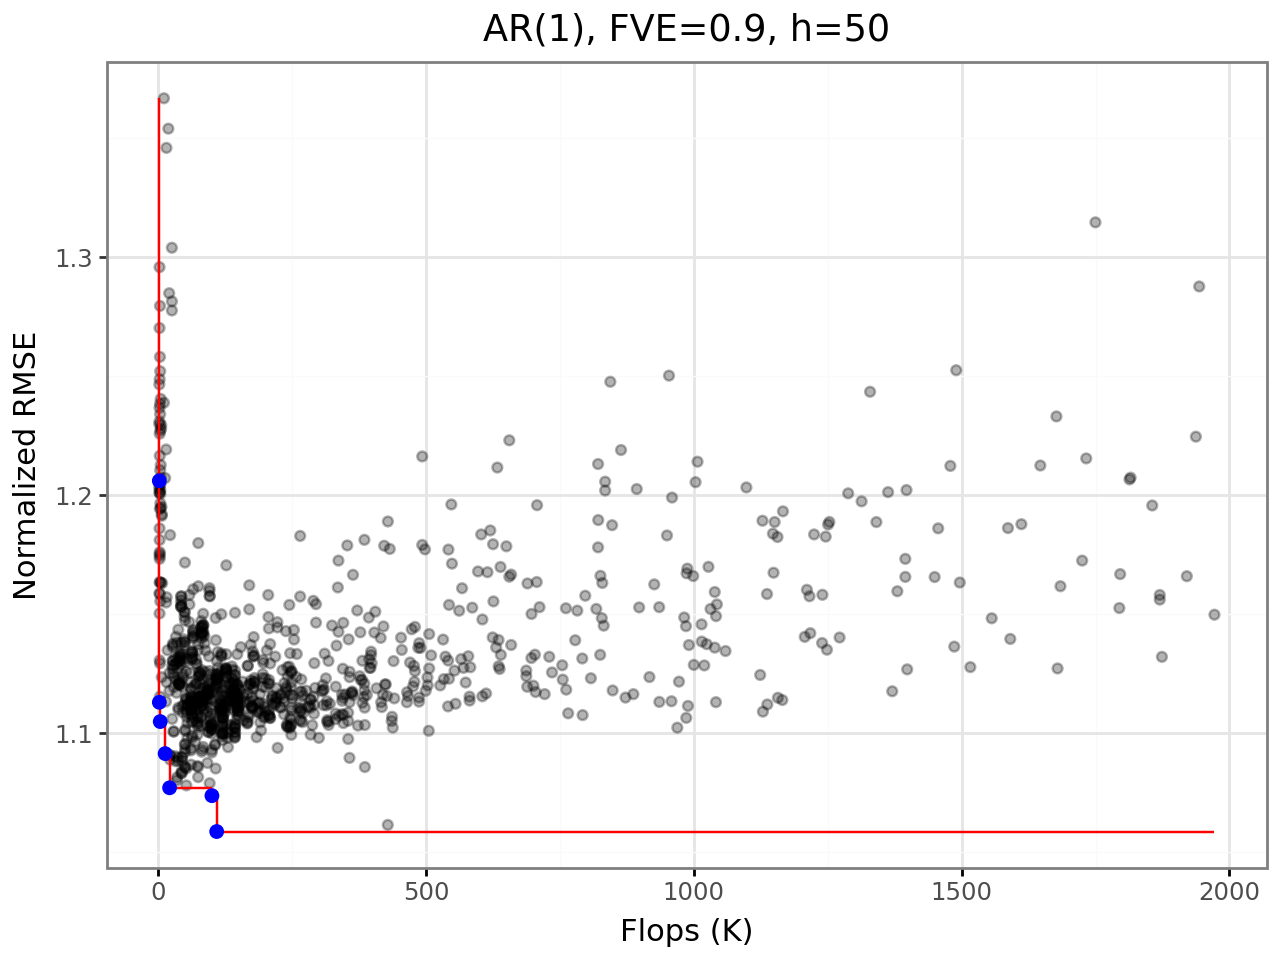

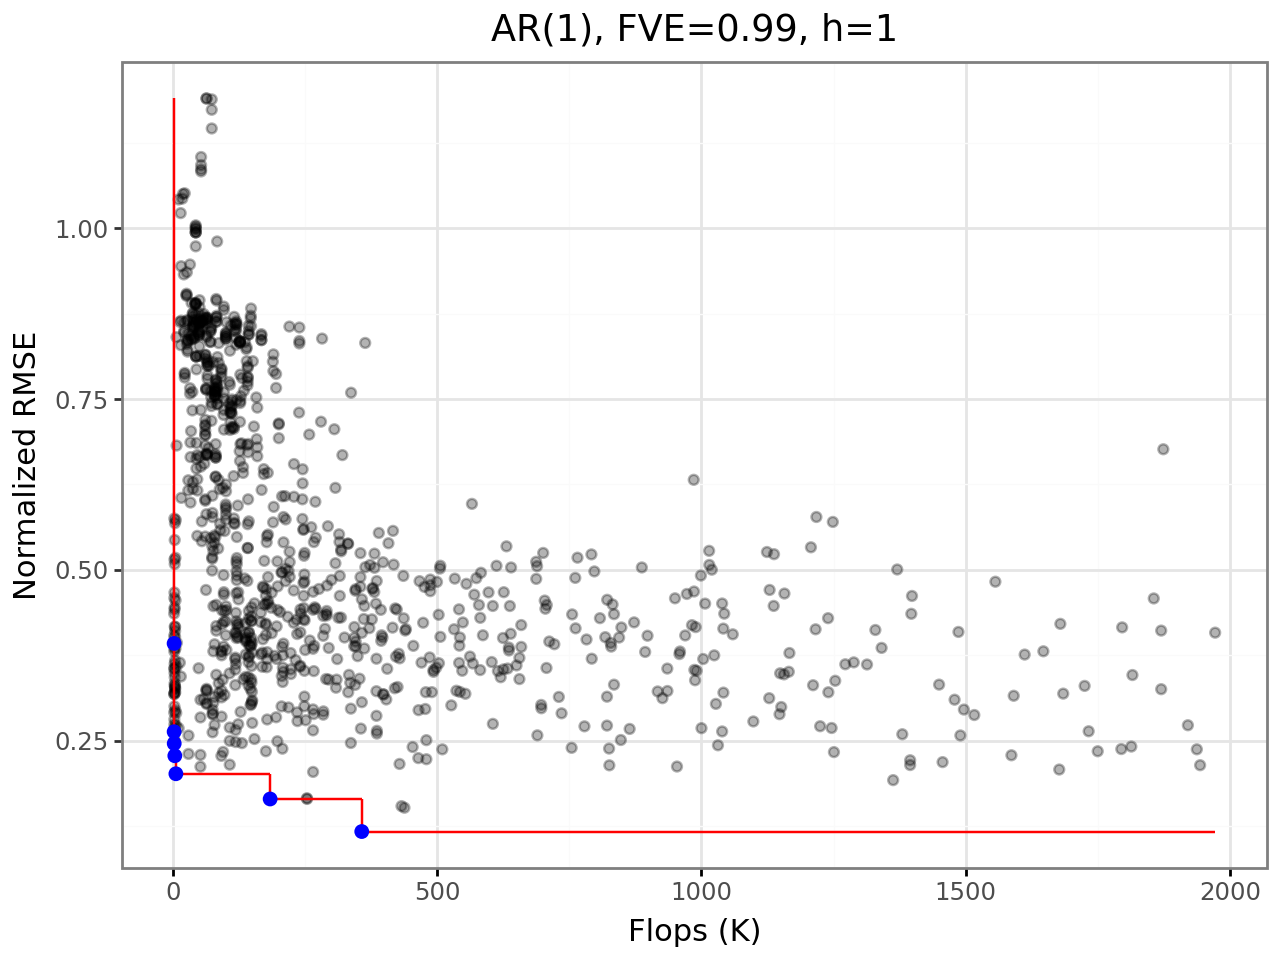

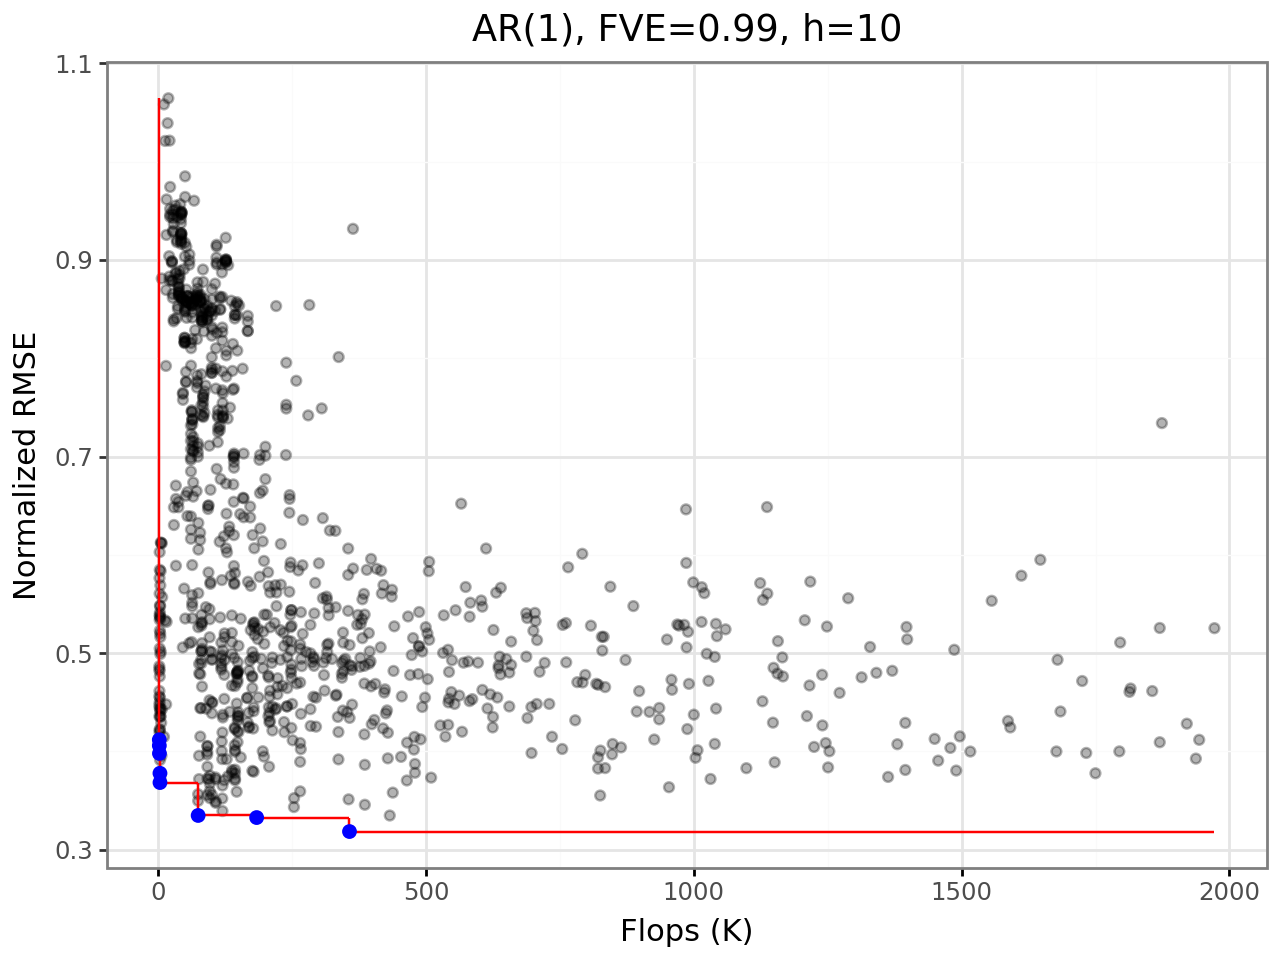

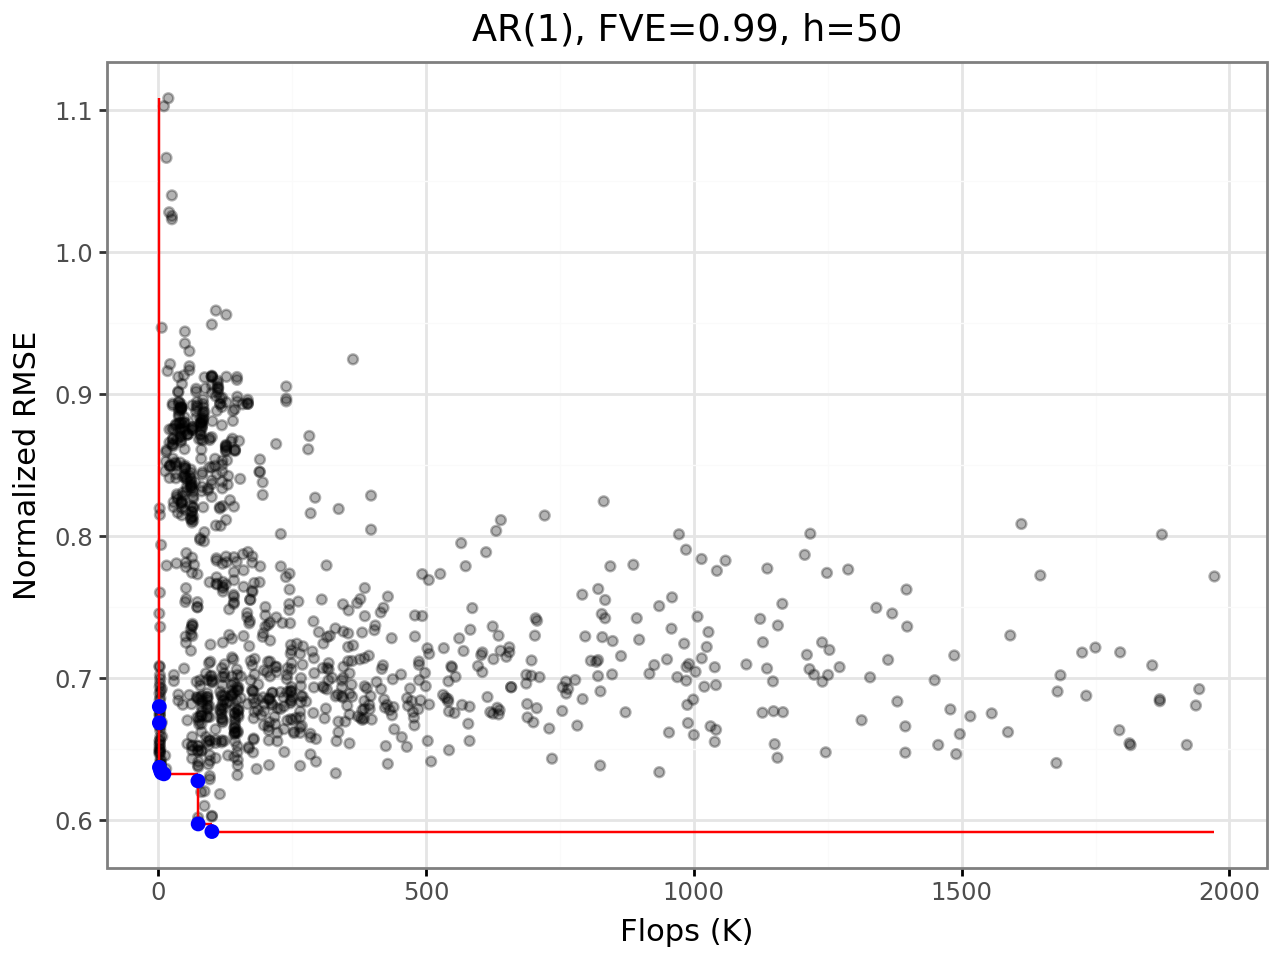

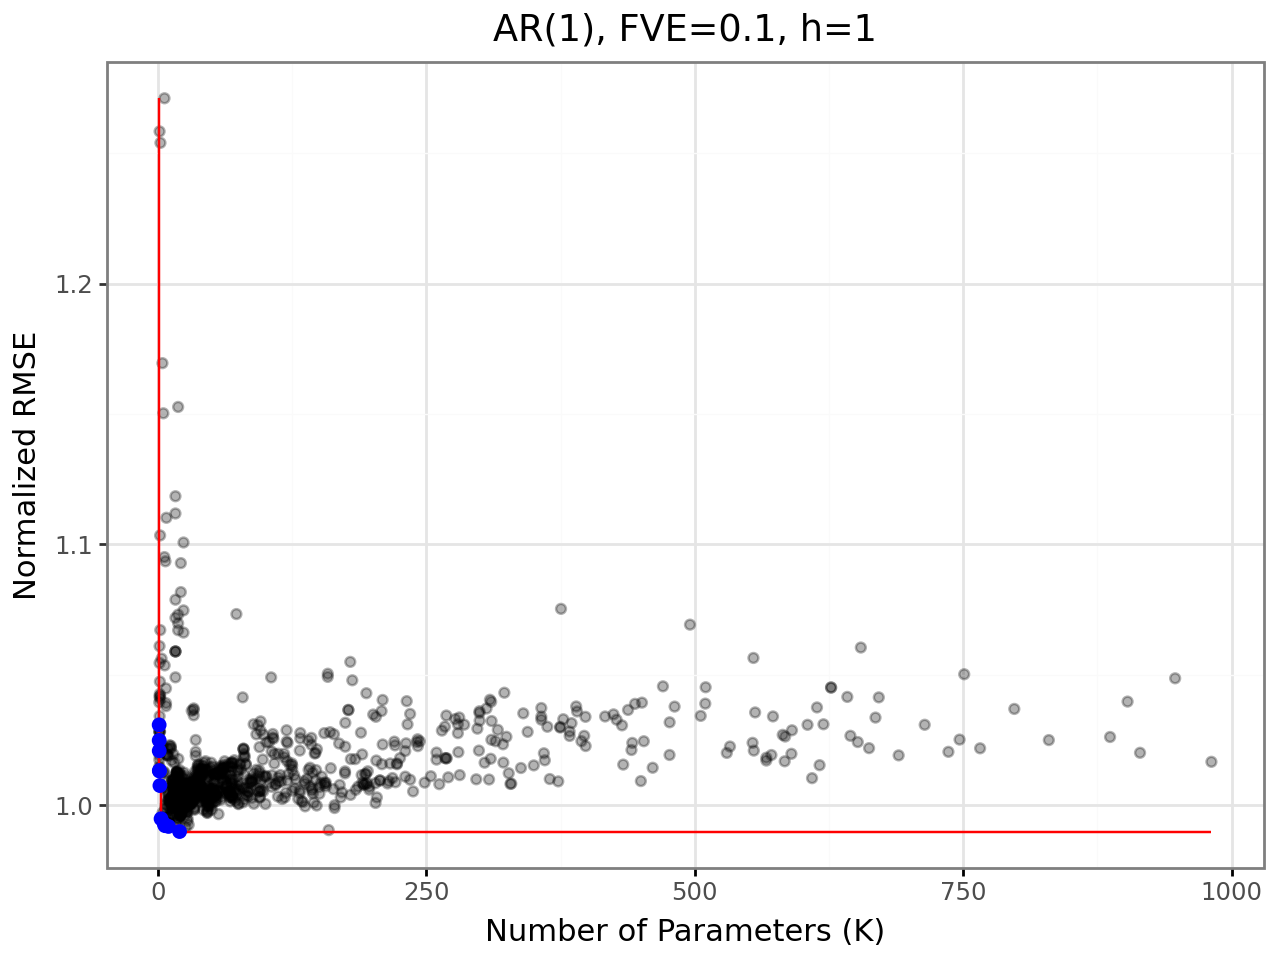

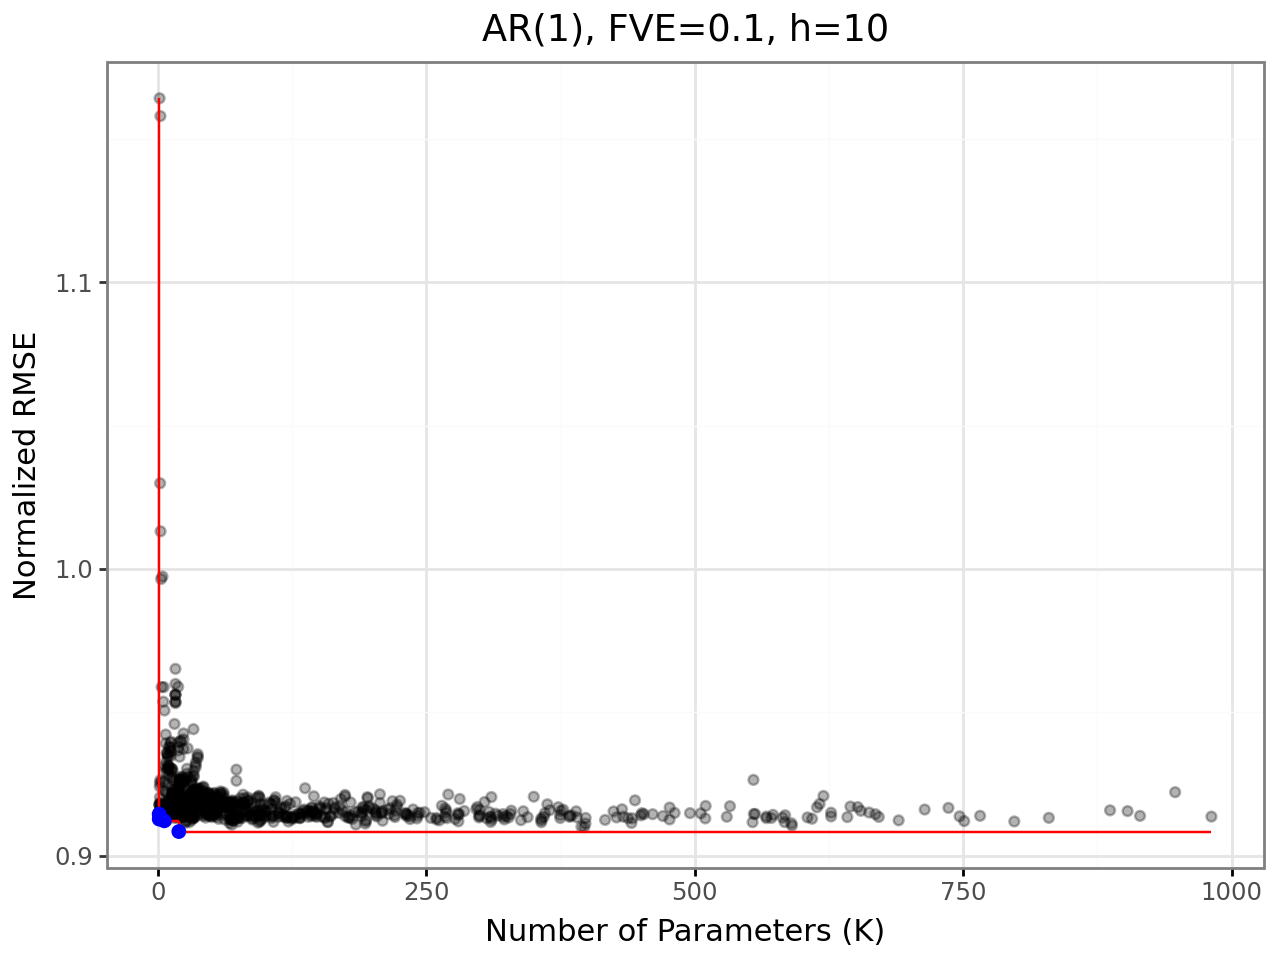

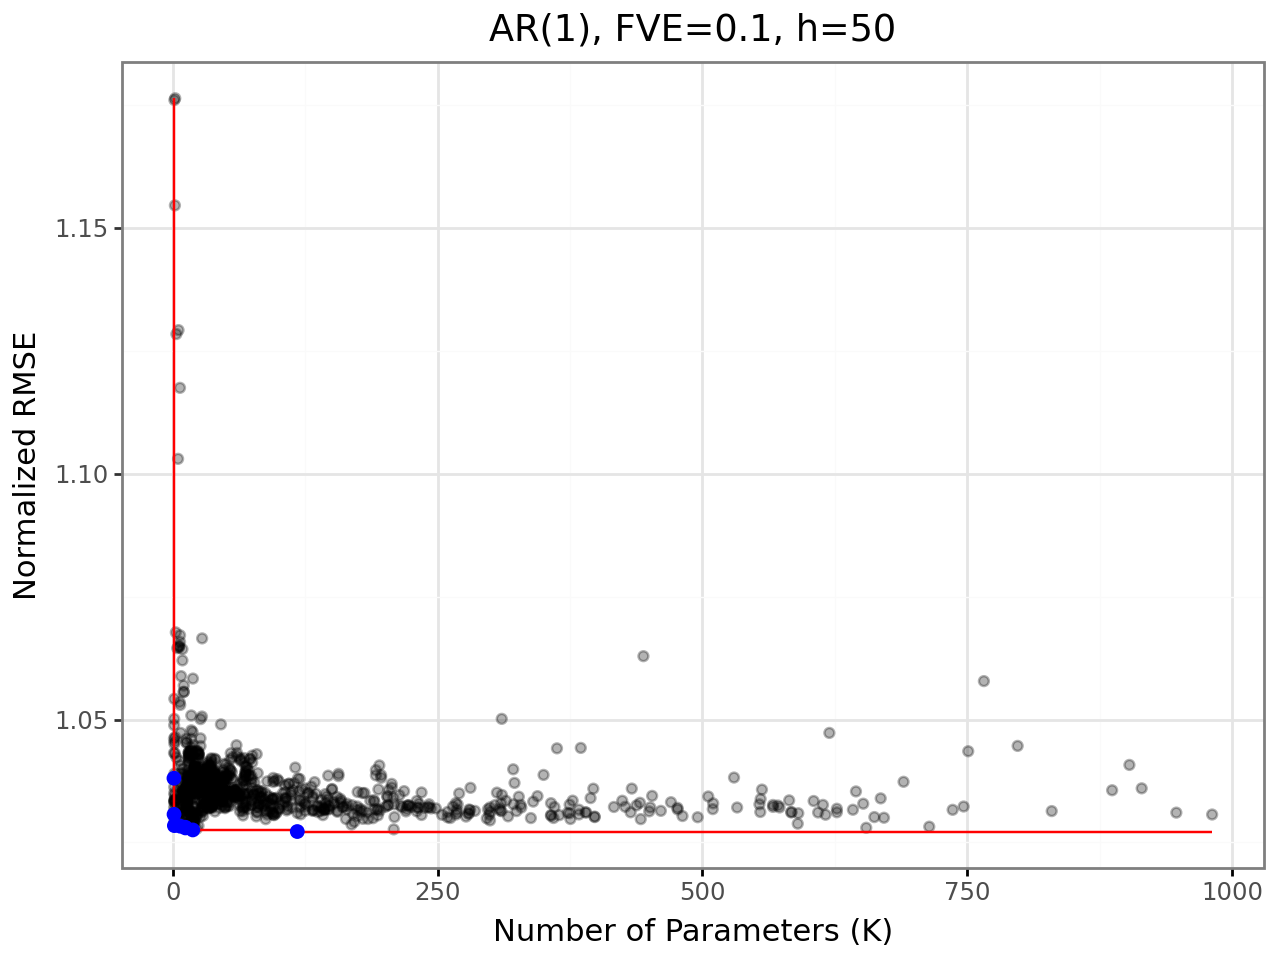

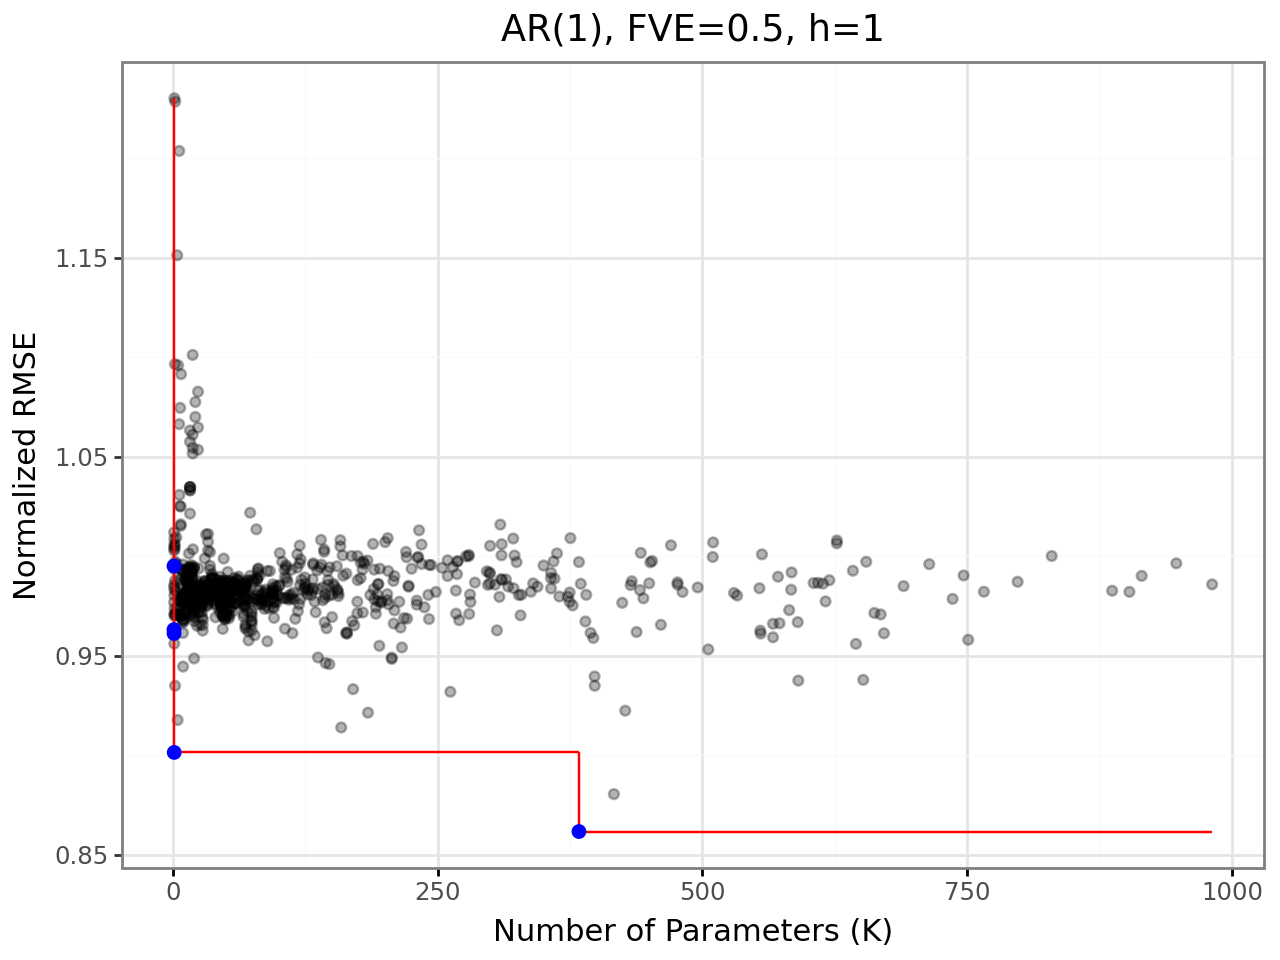

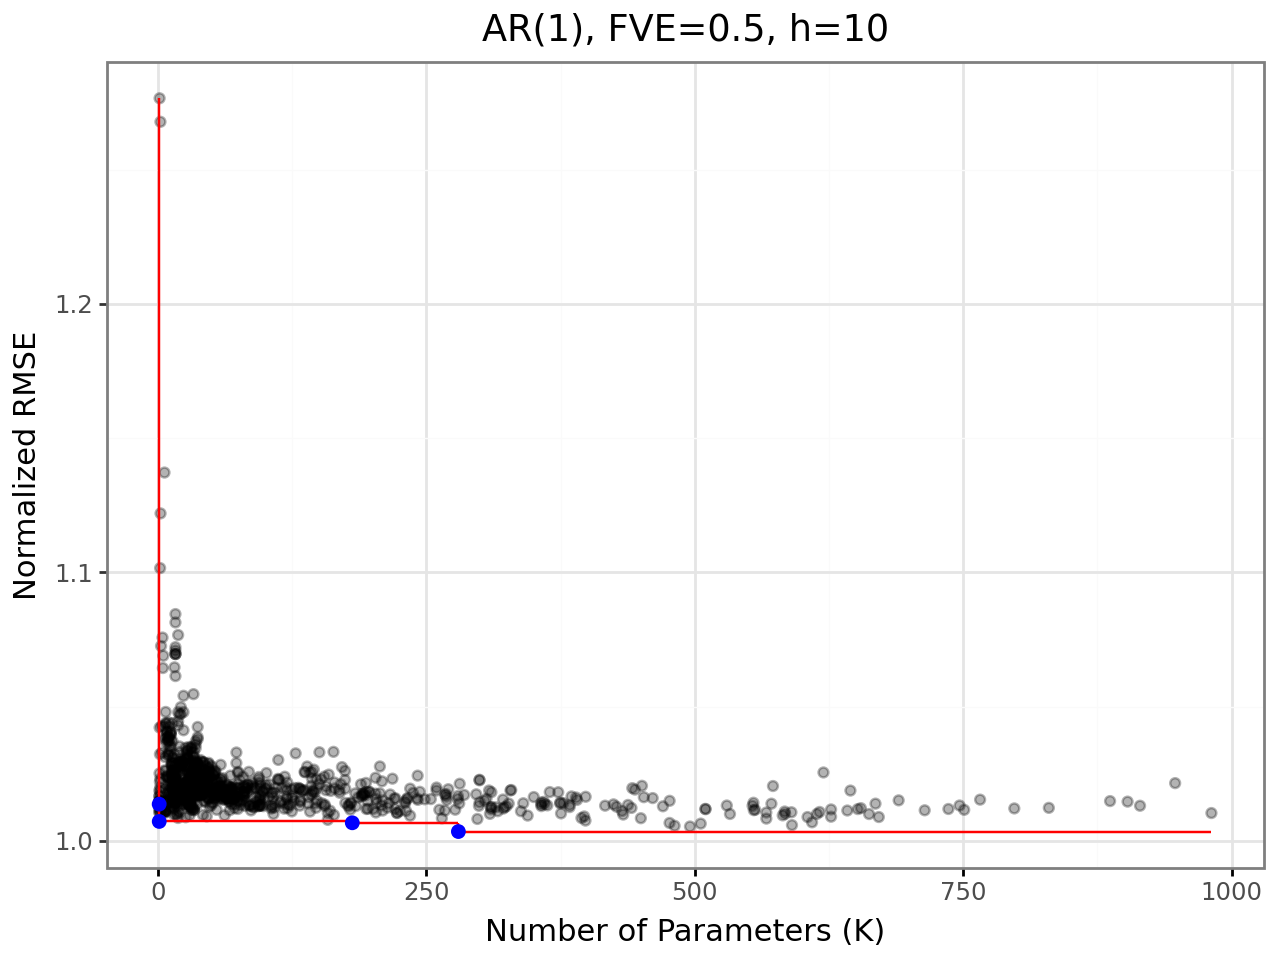

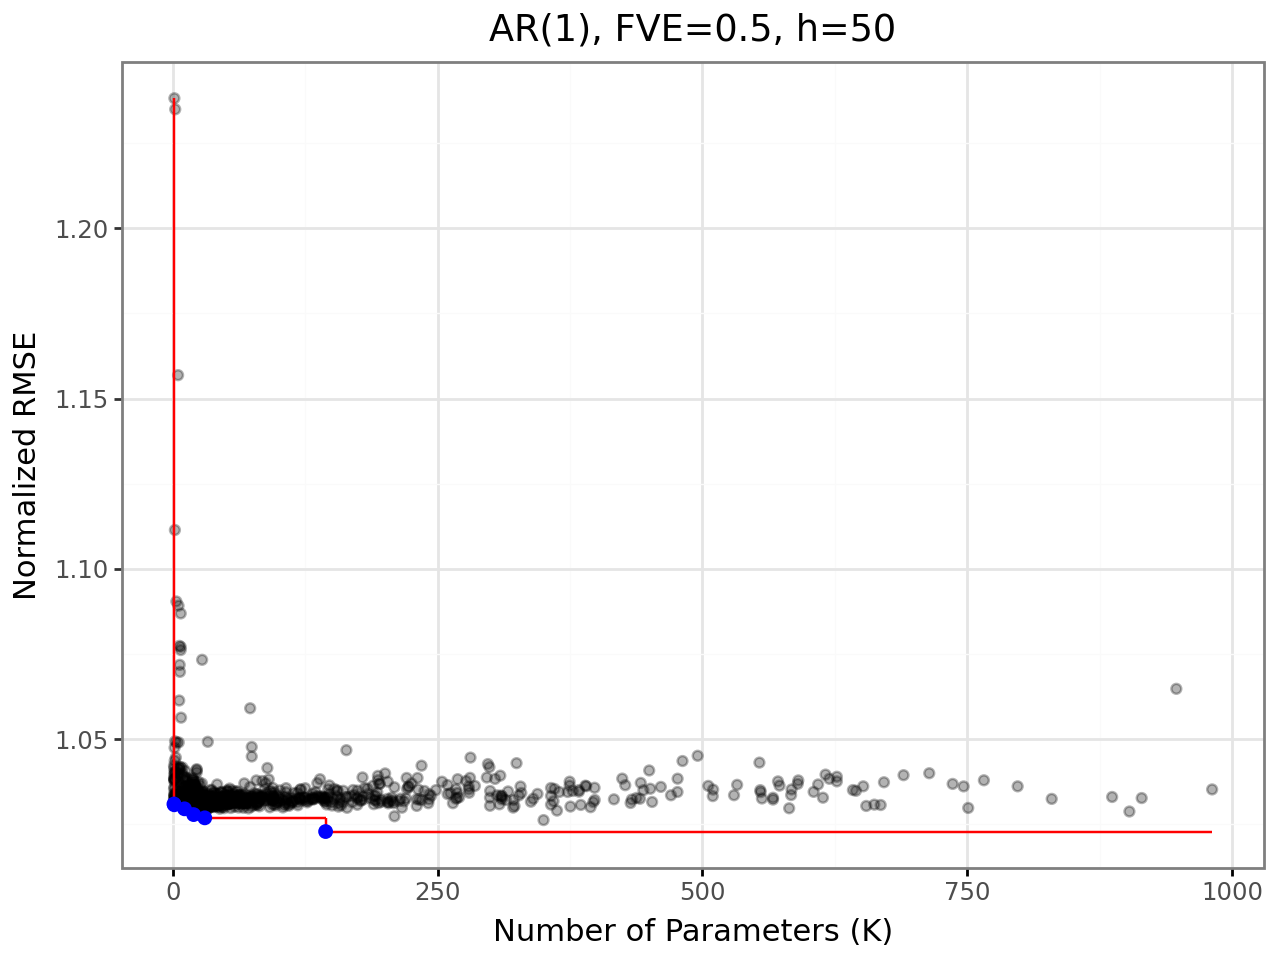

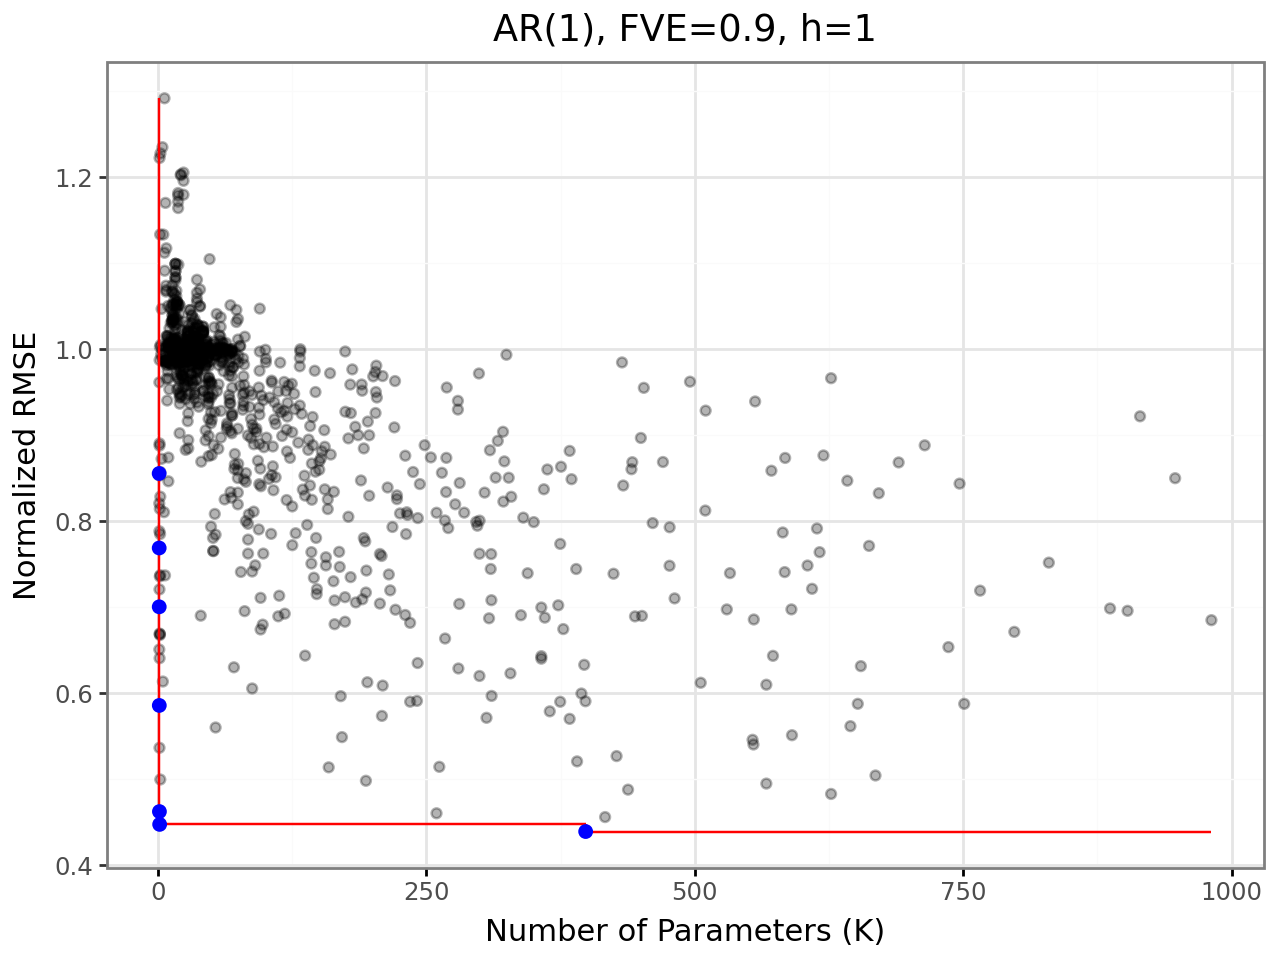

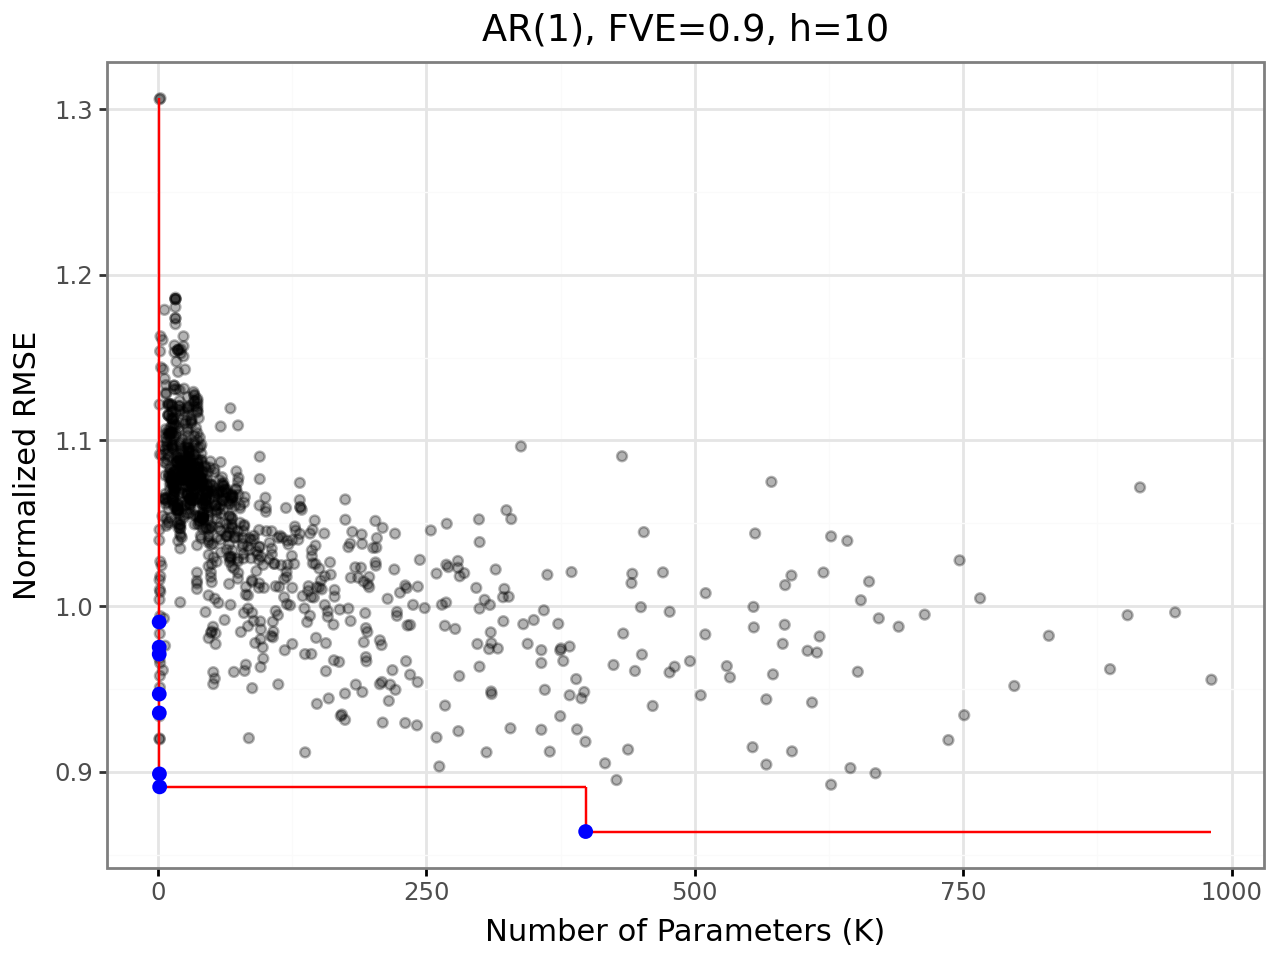

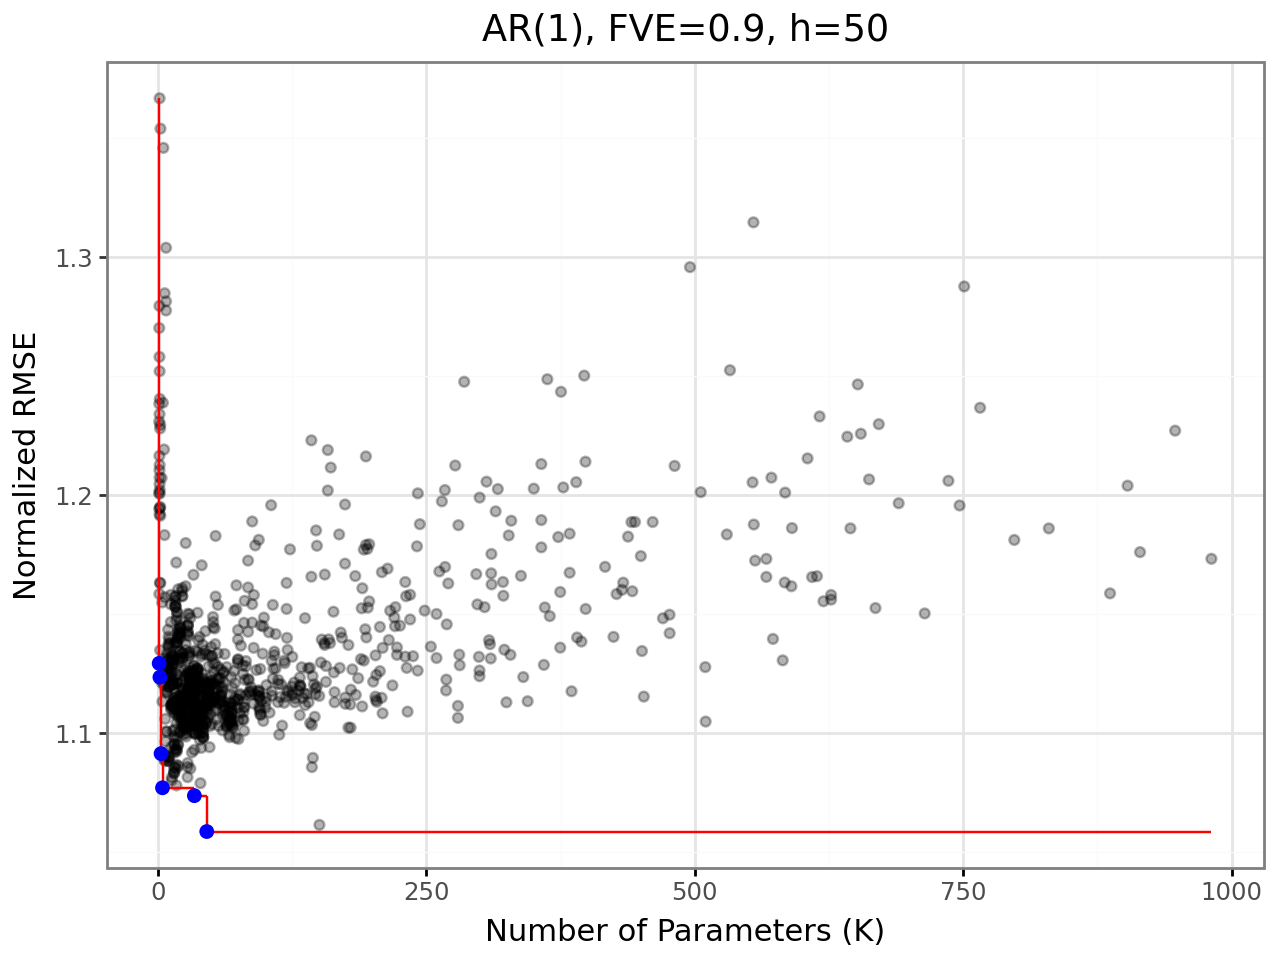

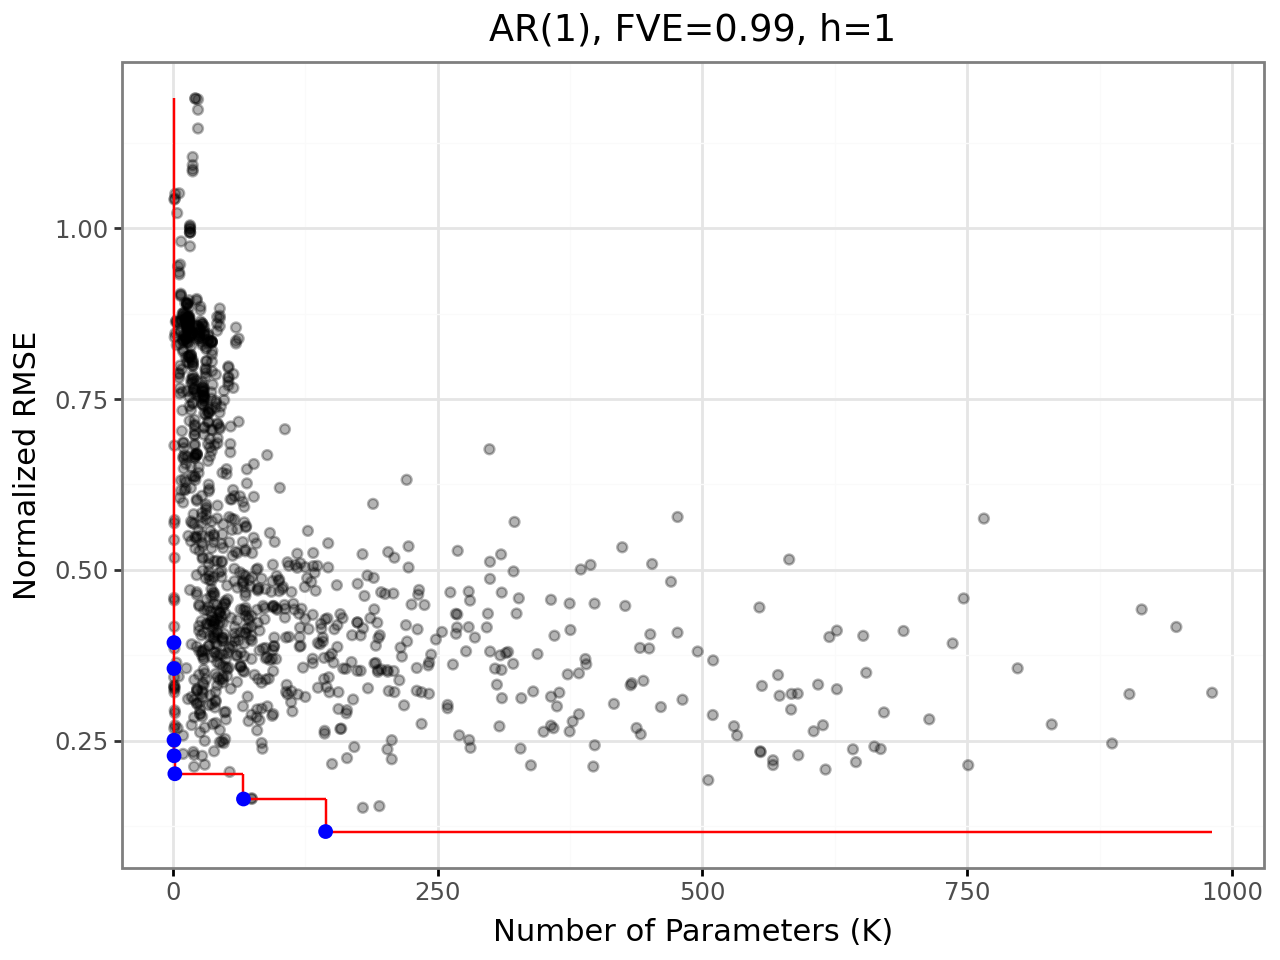

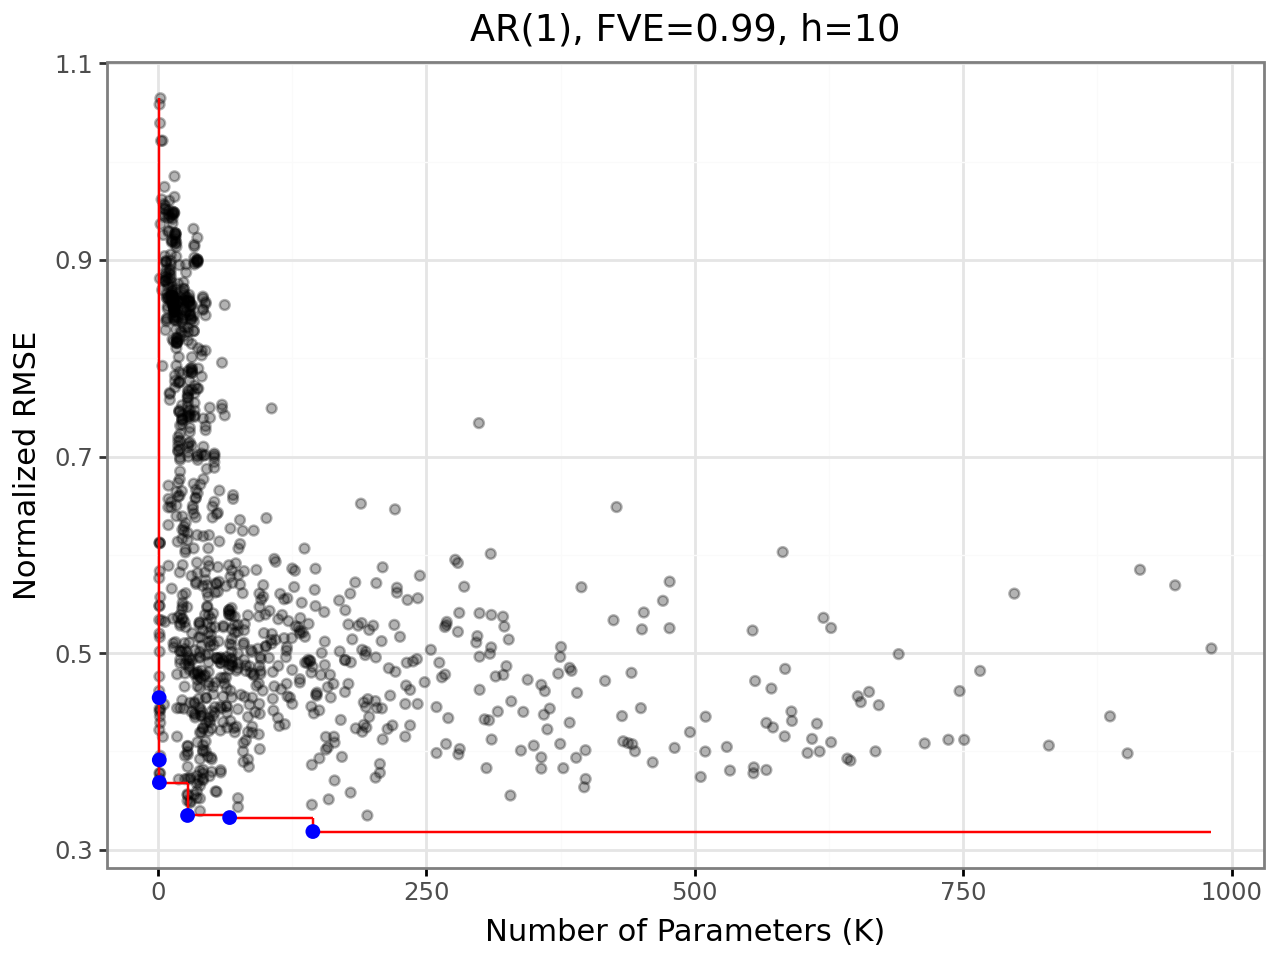

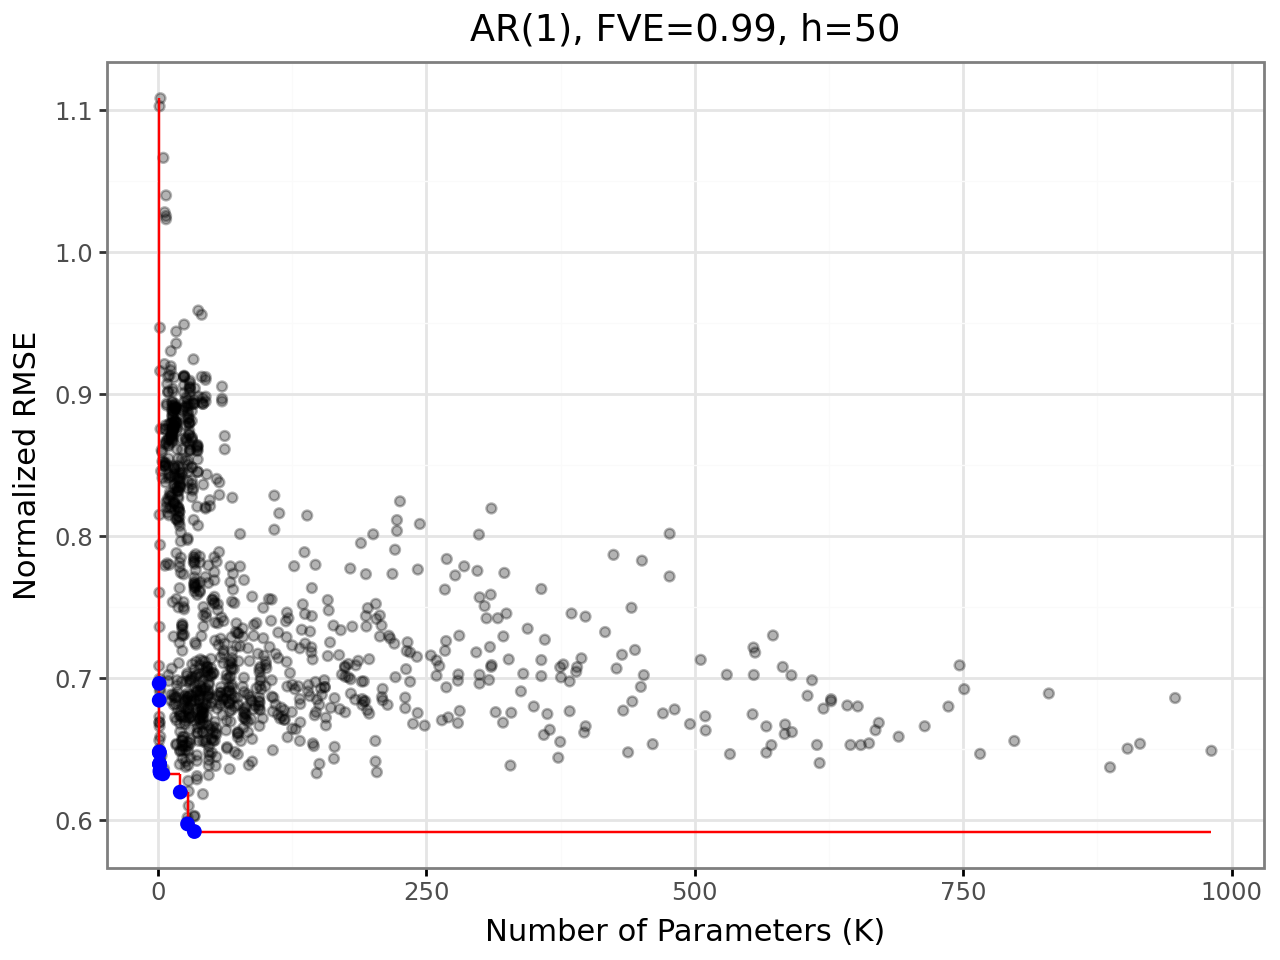

In [105]:
### create a single pareto frontier plot for each combination of metrics, horizons, and fves
save = False
fves = [0.1, 0.5, 0.9, 0.99]
metrics = ["flops", "num_params"]
hs = [1, 10, 50]

for metric in metrics:
    for fve in fves:
        for h in hs:
            fve_df = pd.read_parquet(get_results_path(fve=fve))
            title = f"AR(1), FVE={fve}, h={h}"
            plot, _, _= make_pareto_frontier_plot(fve_df, [h], metric, title, 0.3, False, True, fve)
            plot.show()
            if save:
                save_as_pdf_pages([plot], f"{title}_{metric}.pdf")

### Plots of X-Ray Flux

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 188 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 4 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_hline : Removed 4 rows containing missing values.


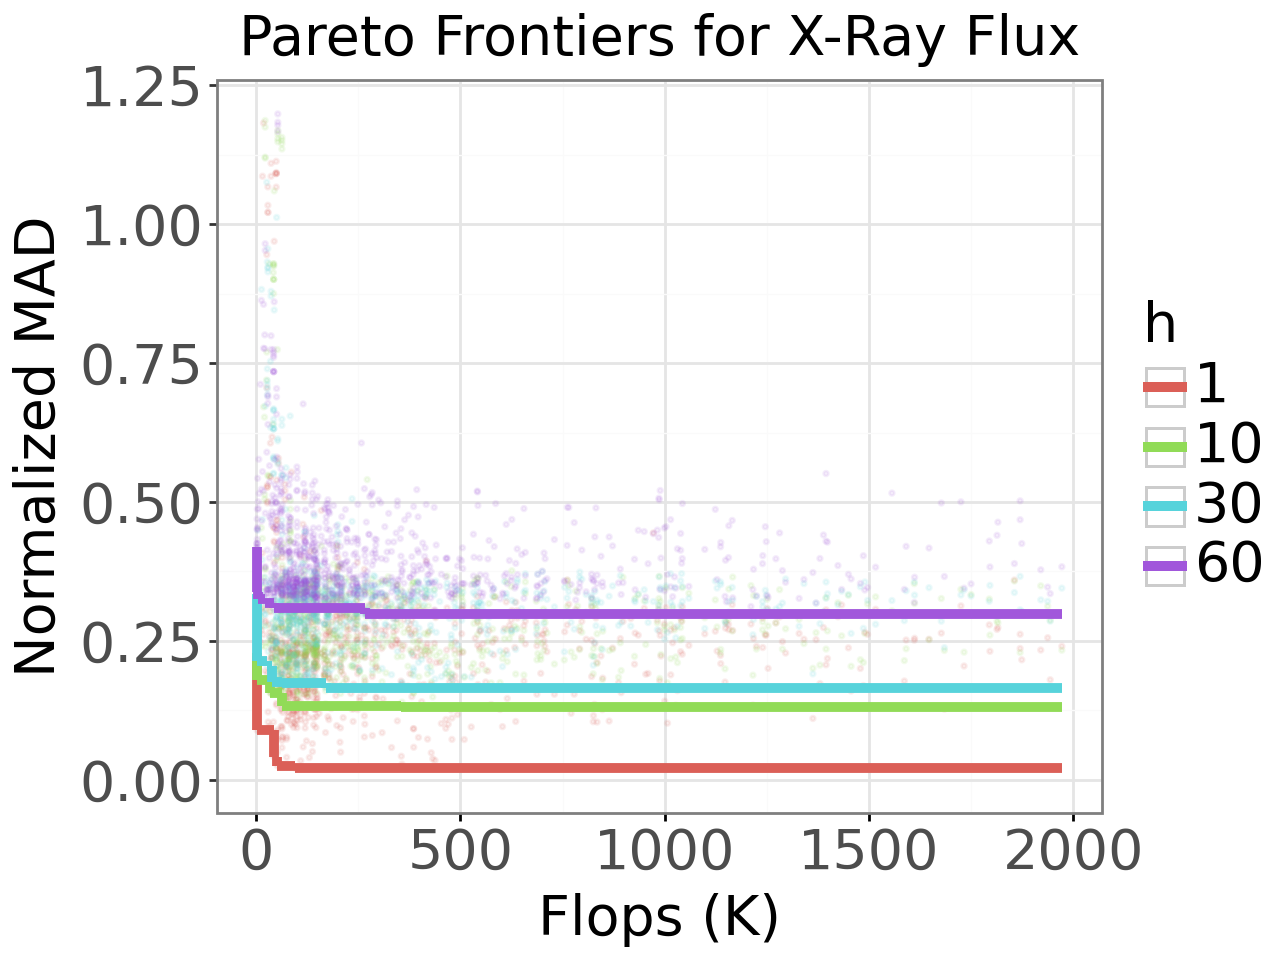

   hyper_idx  mean_squared_error      RMSE           MAD  coverage_accuracy  \
0          0        9.342233e-12  0.000003  1.552413e-07               0.96   
1          1        1.018612e-11  0.000003  1.625507e-07               0.94   
2          2        9.391230e-12  0.000003  1.581574e-07               0.95   
3          3        1.016153e-11  0.000003  1.659266e-07               0.94   
4          4        9.374589e-12  0.000003  1.786870e-07               0.96   

     flops  num_params            sd  normalized_rmse  boundary_flags   h  
0   149.28       40.39  3.312755e-07         0.321506           False  60  
1   123.32       37.88  3.312755e-07         0.336644           False  60  
2  1166.42      314.46  3.312755e-07         0.327545           False  60  
3   137.88       58.34  3.312755e-07         0.343635           False  60  
4   821.18      357.01  3.312755e-07         0.370062           False  60  


In [107]:
save = False
hs = [1, 10, 30, 60]
dfs = []
result_list = []

title = f"Pareto Frontiers for X-Ray Flux"
flux_df = pd.read_parquet(get_results_path(fve=0.1, base_dir="Xray_Flux"))
flux_MAD = np.median(np.abs(flux_df["observed"] - np.median(flux_df["observed"])))

### combine the results of single pareto frontier plots at different horizons
for h in hs:
    _, enhanced_boundary_df_2, results = make_pareto_frontier_plot(
        flux_df, [h], "flops", "", 0.3, False, False, flux_MAD=flux_MAD,fve=0.1)
    dfs.append(enhanced_boundary_df_2)
    result_list.append(results)
    
### creat a combined plot with multiple frontiers 
plot = (make_multi_frontier_plot(dfs, title, result_list) + ylab("Normalized MAD") + 
        theme(text=element_text(size=20)) + ylim(0, 1.2))
plot.show()
print(results.head())

if save:
    save_as_pdf_pages([plot], f"{title}.pdf")

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 39 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


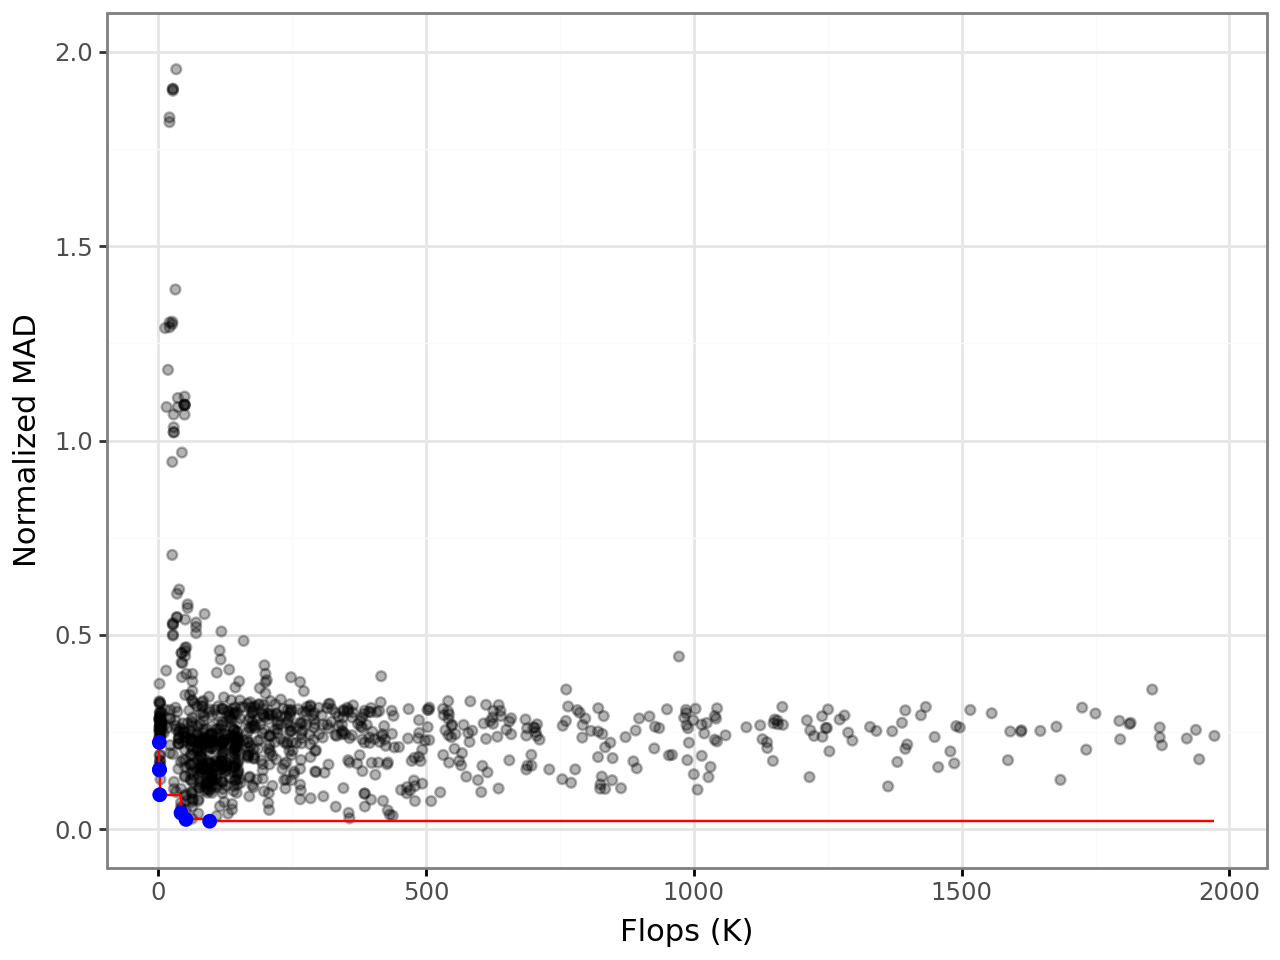

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 15 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


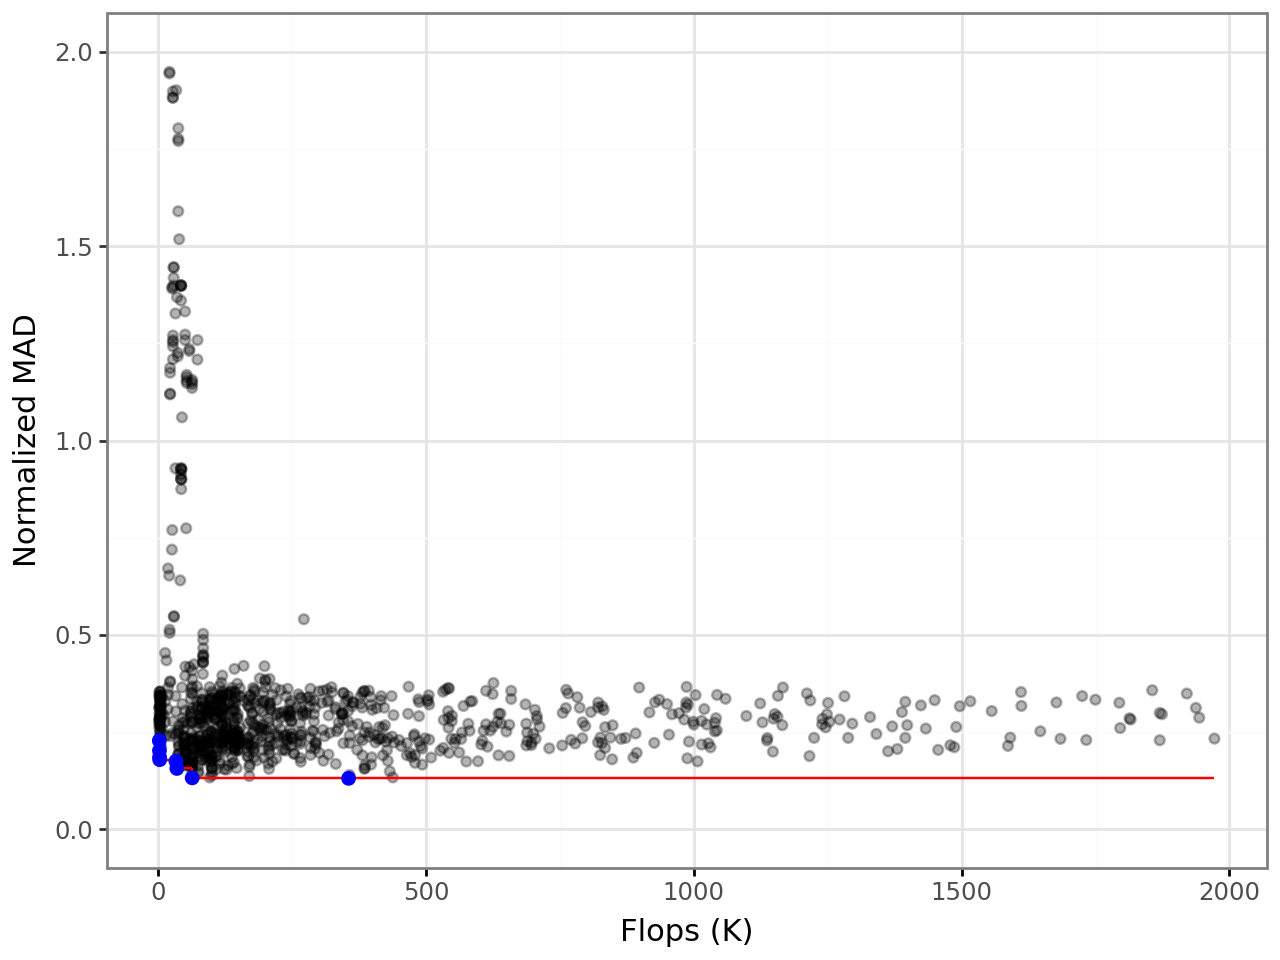

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 14 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


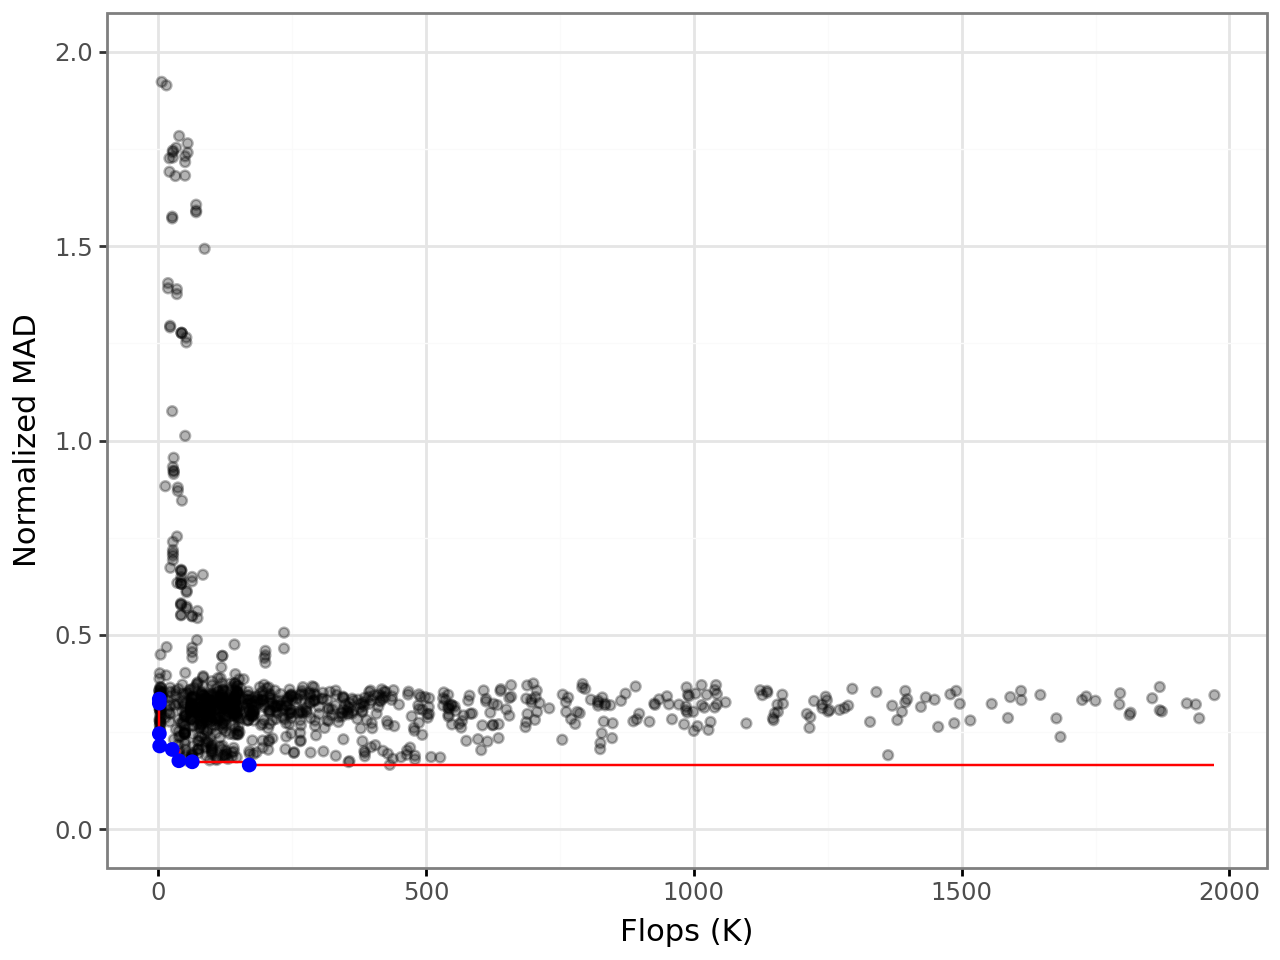

c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 27 rows containing missing values.
c:\ProgramData\anaconda3\envs\autogluon_env\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_segment : Removed 1 rows containing missing values.


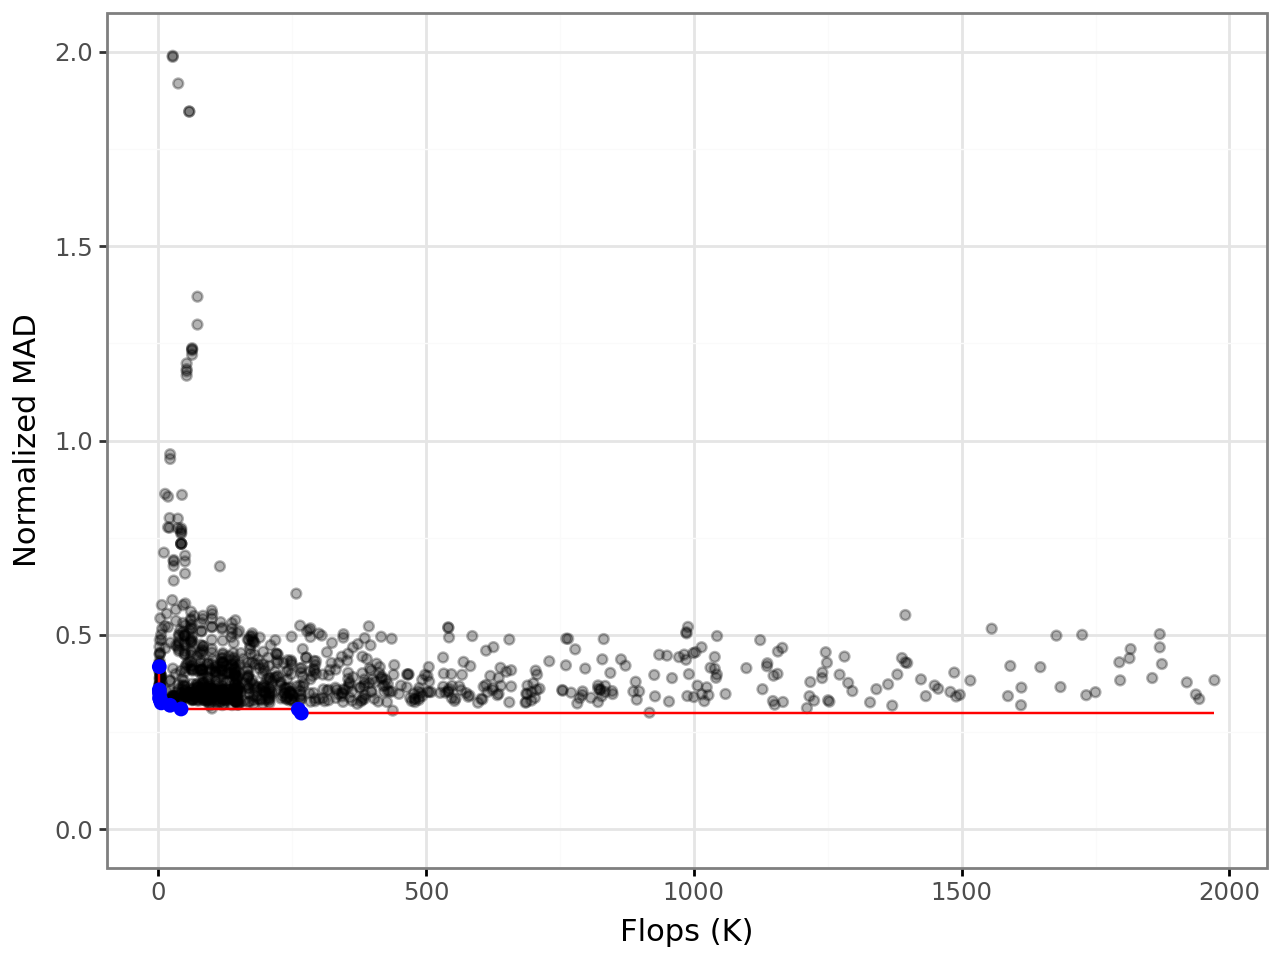

In [106]:
### create a single pareto frontier plot at each horizon

hs = [1, 10, 30, 60]
for h in hs:
    title = f"Xray Flux, h={h}"
    plot, _, _= make_pareto_frontier_plot(results=flux_df, h=[h], metric="flops", 
                                          title="", alpha=0.3, flux_MAD=flux_MAD)
    plot = plot + ylim(0,2)
    plot.show()